<a href="https://colab.research.google.com/github/deepika2502/Udacity-Data-Engineering-Projects/blob/master/Enable_Prevent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semester Project: Mohd AAMIR, Deepika SIVASANKARAN**
# Detecting prevent and enable event relationships types in text
Done under the guidance of
    **Raphaël TRONCY,
    Pasquale LISENA, 
    Youssra REBBOUD**

# Imports

In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.9 MB/s eta 0:00:00


In [4]:
#! pip install keras-preprocessing

In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch import nn, optim, functional as F
import warnings
warnings.filterwarnings("ignore")


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Enable and prevent sentences


In [ ]:
e_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/enable_df.csv'))
e_df['label'] = 0
p_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/prevent_df.csv'))
p_df['label'] = 1
df = pd.concat([e_df, p_df], ignore_index=True, sort=False)
df_2 = df.copy(deep=True)
df.drop(['Unnamed: 0', 'verb', 'trigger_1', 'trigger_2'], axis=1, inplace=True)


In [ ]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
300,Victoria had not recorded any locally acquired...,2
301,But repeated failures of the quarantine system...,2
302,"Australia -- which has recorded about 30,000 c...",2
303,New current affairs channel GB News on Wednesd...,2


In [ ]:
'''
df = pd.concat([df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
'''

"\ndf = pd.concat([df, n_df], ignore_index=True, sort=False)\ndf.drop(['Unnamed: 0'], axis=1, inplace=True)\n"

In [ ]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
300,Victoria had not recorded any locally acquired...,2
301,But repeated failures of the quarantine system...,2
302,"Australia -- which has recorded about 30,000 c...",2
303,New current affairs channel GB News on Wednesd...,2


In [ ]:
df.shape

(305, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  305 non-null    object
 1   label     305 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


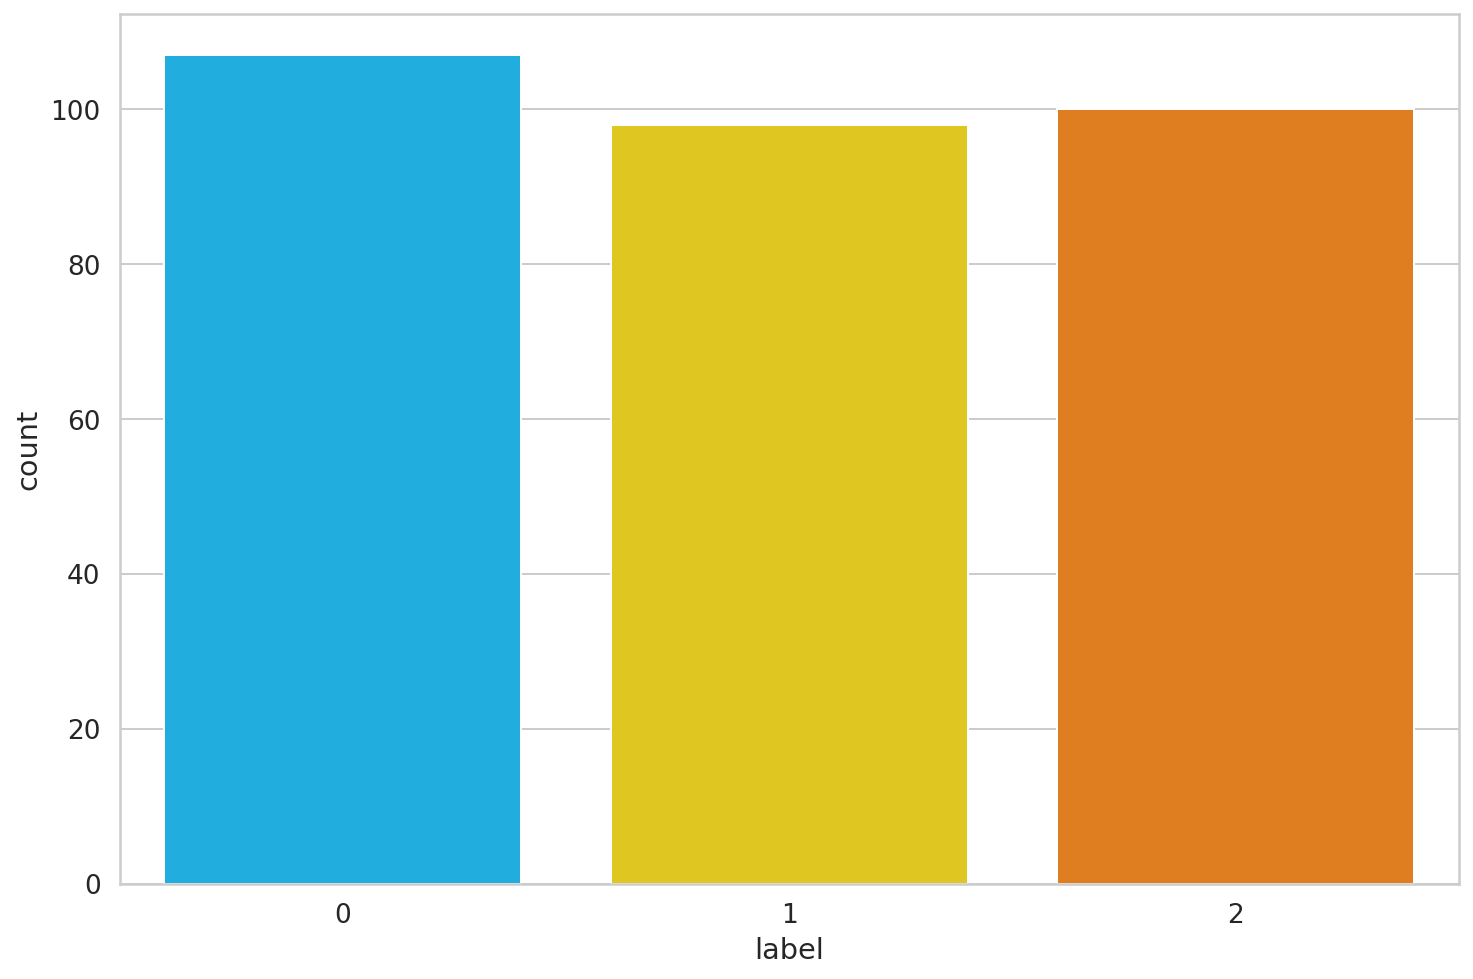

In [ ]:
sns.countplot(df.label)
plt.xlabel('label');

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))

encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))

encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []

for txt in df.sentence:

  tokens = tokenizer.encode(txt, max_length=512)

  token_lens.append(len(tokens))

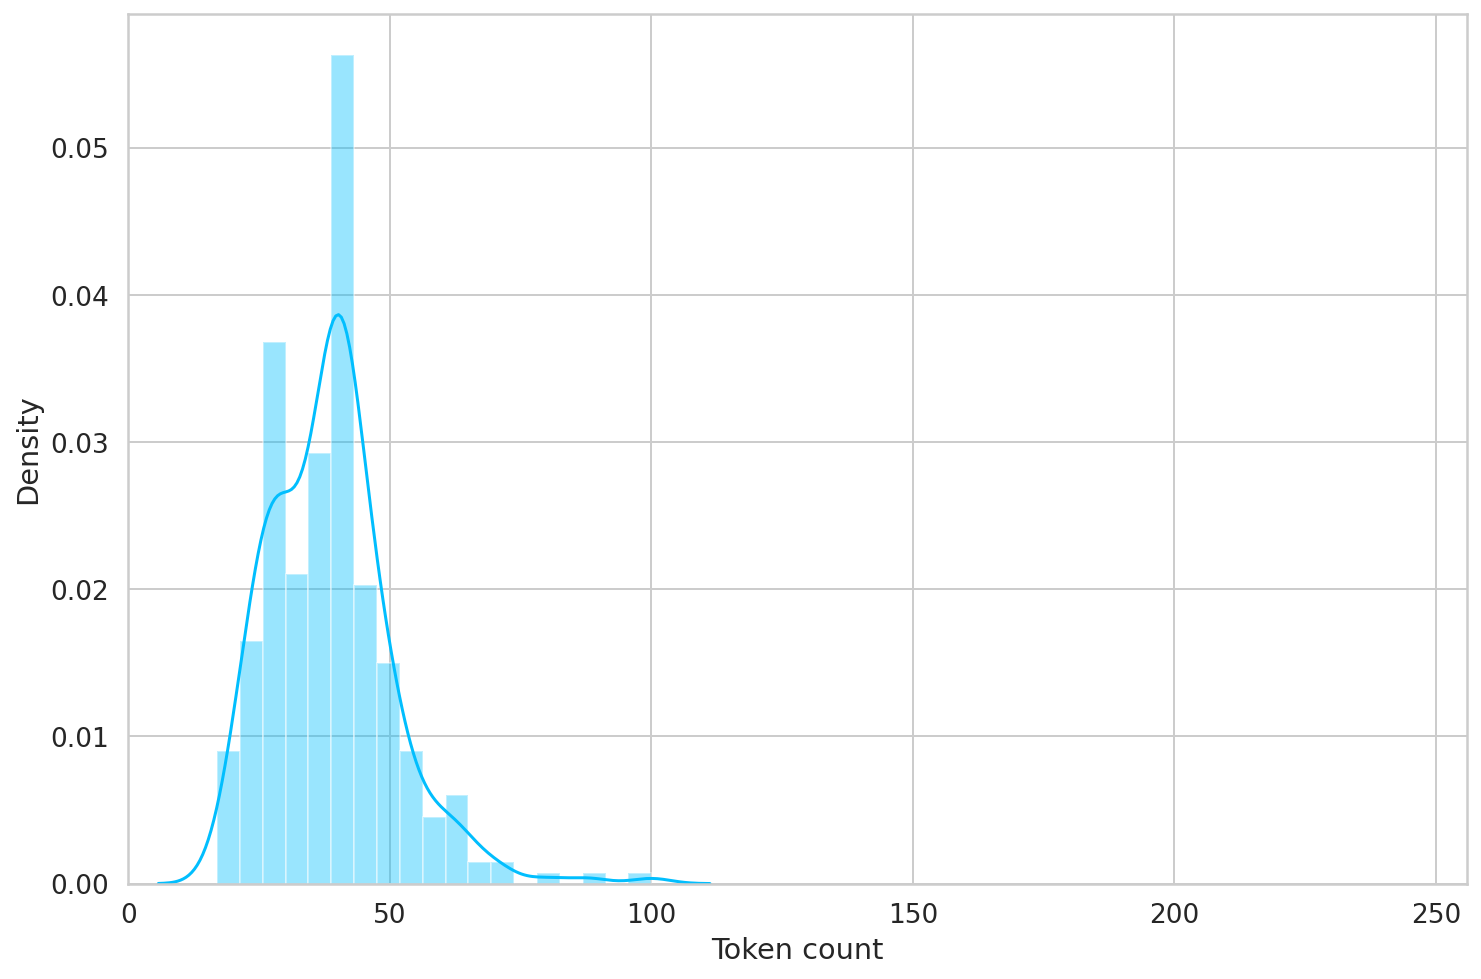

In [ ]:
sns.distplot(token_lens)

plt.xlim([0, 256]);

plt.xlabel('Token count');

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, sentence, label, tokenizer, max_len):

    self.sentence = sentence

    self.label = label

    self.tokenizer = tokenizer

    self.max_len = max_len

  def __len__(self):

    return len(self.sentence)

  def __getitem__(self, item):

    sentence = str(self.sentence[item])

    label = self.label[item]

    encoding = self.tokenizer.encode_plus(

      sentence,

      add_special_tokens=True,

      max_length=self.max_len,

      return_token_type_ids=False,

      pad_to_max_length=True,

      return_attention_mask=True,

      return_tensors='pt',

    )

    return {

      'sentence': sentence,

      'input_ids': encoding['input_ids'].flatten(),

      'attention_mask': encoding['attention_mask'].flatten(),

      'label': torch.tensor(label, dtype=torch.long)

    }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED

)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((259, 2), (23, 2), (23, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(

    sentence=df.sentence.to_numpy(),

    label=df.label.to_numpy(),

    tokenizer=tokenizer,

    max_len=max_len

  )

  return DataLoader(

    ds,

    batch_size=batch_size,

    num_workers=4

  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

data.keys()

dict_keys(['sentence', 'input_ids', 'attention_mask', 'label'])

In [ ]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['label'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = bert_model(

  input_ids=encoding['input_ids'],

  attention_mask=encoding['attention_mask']

)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class EP(nn.Module):

  def __init__(self, n_classes):

    super(EP, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p=0.1)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    output = self.drop(pooled_output)

    return self.out(output)

In [ ]:
model = EP(2)

model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length

print(attention_mask.shape)

torch.Size([32, 100])
torch.Size([32, 100])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1958, 0.4263, 0.3779],
        [0.2329, 0.3490, 0.4181],
        [0.2233, 0.3982, 0.3785],
        [0.1976, 0.3838, 0.4186],
        [0.3894, 0.2414, 0.3692],
        [0.2648, 0.2817, 0.4535],
        [0.2501, 0.3491, 0.4008],
        [0.2753, 0.3122, 0.4125],
        [0.3122, 0.2664, 0.4214],
        [0.2497, 0.3286, 0.4217],
        [0.2672, 0.3295, 0.4033],
        [0.2305, 0.3091, 0.4604],
        [0.2378, 0.4082, 0.3540],
        [0.2877, 0.2602, 0.4521],
        [0.2830, 0.3427, 0.3743],
        [0.2396, 0.3154, 0.4450],
        [0.2135, 0.3892, 0.3973],
        [0.2837, 0.2364, 0.4799],
        [0.2247, 0.4290, 0.3463],
        [0.2402, 0.3865, 0.3733],
        [0.3098, 0.2456, 0.4445],
        [0.3052, 0.2779, 0.4169],
        [0.2165, 0.4051, 0.3784],
        [0.2369, 0.2947, 0.4684],
        [0.2808, 0.2526, 0.4667],
        [0.2381, 0.3290, 0.4329],
        [0.2780, 0.3081, 0.4139],
        [0.1765, 0.3626, 0.4609],
        [0.3004, 0.3170, 0.3826],
        [0.248

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr= 2e-5, correct_bias=True)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(

  optimizer,

  num_warmup_steps=0,

  num_training_steps=total_steps

)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(

  model,

  data_loader,

  loss_fn,

  optimizer,

  device,

  scheduler,

  n_examples

):

  model = model.train()

  losses = []

  correct_predictions = 0

  for d in data_loader:

    input_ids = d["input_ids"].to(device)

    attention_mask = d["attention_mask"].to(device)

    targets = d["label"].to(device)

    outputs = model(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []

  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)

      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')

  print('-' * 10)

  train_acc, train_loss = train_epoch(

    model,

    train_data_loader,

    loss_fn,

    optimizer,

    device,

    scheduler,

    len(df_train)

  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(

    model,

    val_data_loader,

    loss_fn,

    device,

    len(df_val)

  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc.item())

  history['train_loss'].append(train_loss.item())

  history['val_acc'].append(val_acc.item())

  history['val_loss'].append(val_loss.item())

  if val_acc > best_accuracy:

    torch.save(model.state_dict(), 'best_model_state.bin')

    best_accuracy = val_acc



Epoch 1/10
----------
Train loss 1.1195089022318523 accuracy 0.35135135135135137
Val   loss 1.0597426891326904 accuracy 0.3913043478260869

Epoch 2/10
----------
Train loss 1.0368821687168546 accuracy 0.41312741312741313
Val   loss 0.9999704957008362 accuracy 0.5217391304347826

Epoch 3/10
----------
Train loss 0.9711148738861084 accuracy 0.5405405405405406
Val   loss 0.9646905660629272 accuracy 0.4782608695652174

Epoch 4/10
----------
Train loss 0.9210661384794447 accuracy 0.5945945945945946
Val   loss 0.9159365296363831 accuracy 0.5652173913043478

Epoch 5/10
----------
Train loss 0.8390331665674845 accuracy 0.7065637065637066
Val   loss 0.8410506844520569 accuracy 0.6956521739130435

Epoch 6/10
----------
Train loss 0.7652023037274679 accuracy 0.7413127413127414
Val   loss 0.7876224517822266 accuracy 0.7391304347826086

Epoch 7/10
----------
Train loss 0.6665192478232913 accuracy 0.8455598455598455
Val   loss 0.7255685925483704 accuracy 0.8260869565217391

Epoch 8/10
----------
Tra

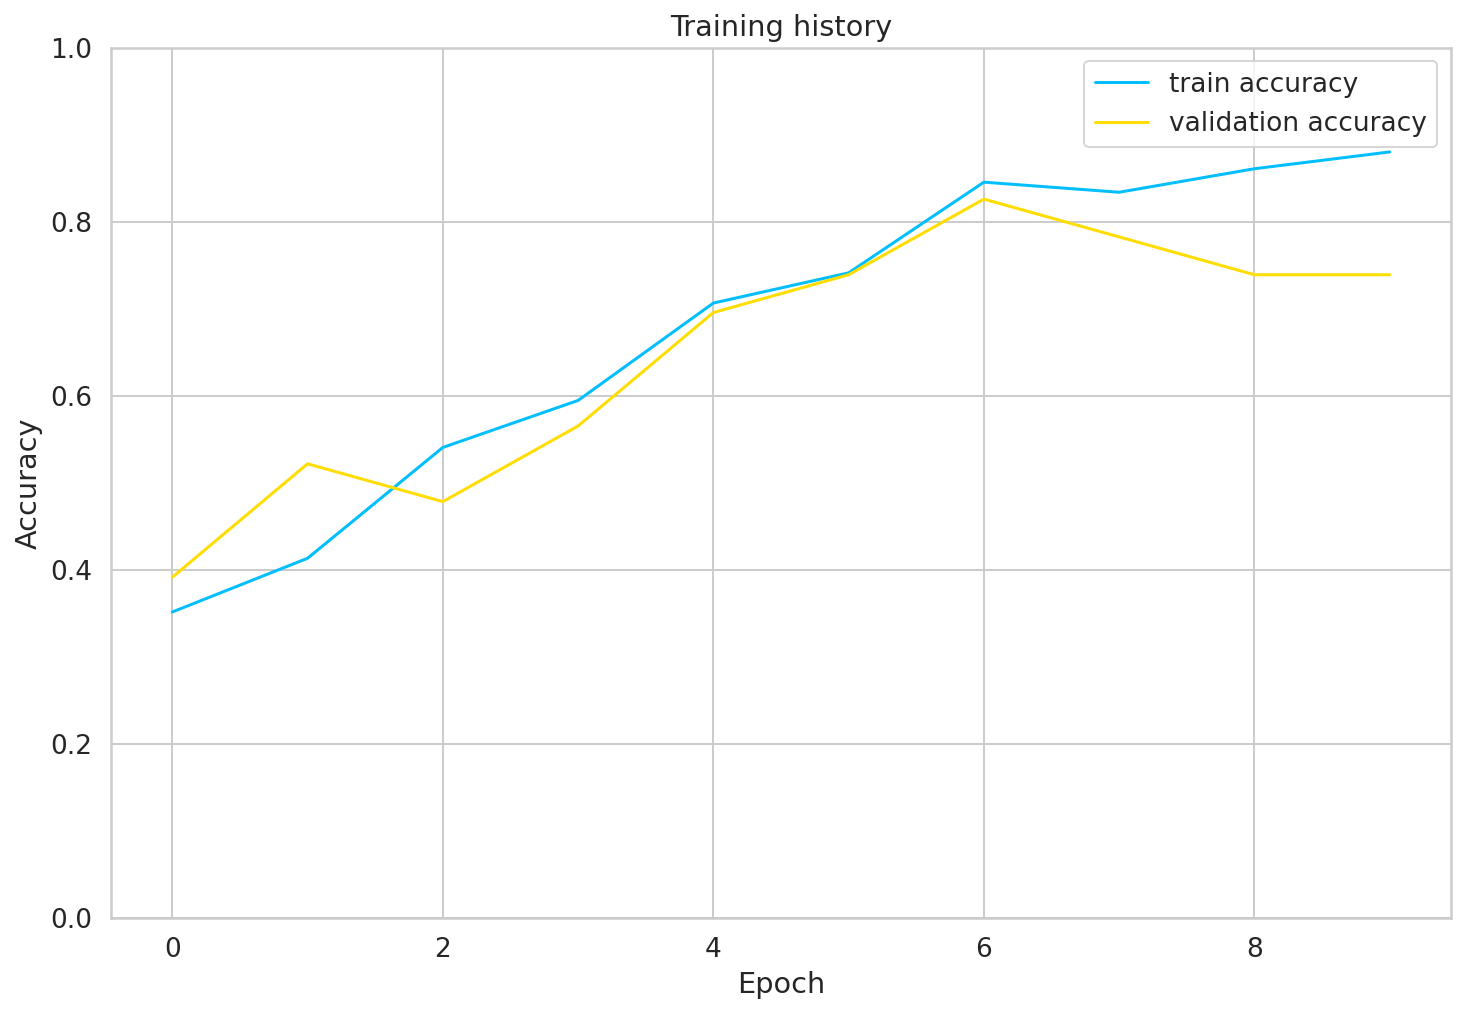

In [ ]:


plt.plot(history['train_acc'], label='train accuracy')

plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [ ]:
val_acc, _ = eval_model(

  model,

  val_data_loader,

  loss_fn,

  device,

  len(df_val)

)
val_acc.item()

0.7391304347826086

In [ ]:
test_acc, _ = eval_model(

  model,

  test_data_loader,

  loss_fn,

  device,

  len(df_test)

)

In [ ]:

test_acc.item()

0.7391304347826086

In [ ]:
def get_predictions(model, data_loader):

  model = model.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d["sentence"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)

      predictions.extend(preds)

      prediction_probs.extend(outputs)

      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred_model_1, y_pred_probs, y_test = get_predictions(

  model,

  test_data_loader

)

In [ ]:
print(classification_report(y_test, y_pred_model_1, target_names=['enable', 'prevent']))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.86      0.75      0.80         8
           2       0.60      0.50      0.55         6

    accuracy                           0.74        23
   macro avg       0.73      0.71      0.72        23
weighted avg       0.74      0.74      0.73        23



In [ ]:
for i in range(len(y_review_texts)):
    print('Text: ' + y_review_texts[i], '\nActual Label: ' + str(y_test[i].item()), '\nPredicted Label: ' + str(y_pred_model_1[i].item()), '\n\n')

Text: Through a strategic collaboration, AWS and Deloitte empower customers to transform their business and innovate faster by combining AWS technologies with Deloitte's deep industry experience. 
Actual Label: 0 
Predicted Label: 0 


Text: For 15 years, BIO KOREA has been a place of bringing together various international academics, professionals, and CEOs of global bio companies to obtain, exchange, and discuss diverse affairs. 
Actual Label: 2 
Predicted Label: 2 


Text:    Bryan, Garnier & Co is a European, full-service growth-focused independent investment banking partnership founded in 1996. 
Actual Label: 2 
Predicted Label: 0 


Text: Migrant workers in Lebanon have been hit hard by its multiple crises and half of them left jobless, the UN warned Wednesday, calling for voluntary returns to be scaled up. 
Actual Label: 0 
Predicted Label: 1 


Text: The following day he may have the perfect present in Manchester City's first Champions League crown. 
Actual Label: 2 
Predicted 

In [ ]:
pd.set_option('max_rows', 99999)
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
5,The Sandbox includes access to Temenos Banking...,0
6,"Among individual companies, Amazon edged up 0....",0
7,Migrant workers in Lebanon have been hit hard ...,0
8,Analysts greeted reports that Senate Republica...,0
9,This is the second time the fragmented centre-...,0


# Enable and neutral sentences


In [ ]:
e_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/enable_df.csv'))
e_df['label'] = 0
n_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/none_df.csv'), nrows=100)
n_df['label'] = 1
df = pd.concat([e_df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0', 'verb', 'trigger_1', 'trigger_2'], axis=1, inplace=True)


In [ ]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
300,Victoria had not recorded any locally acquired...,2
301,But repeated failures of the quarantine system...,2
302,"Australia -- which has recorded about 30,000 c...",2
303,New current affairs channel GB News on Wednesd...,2


In [ ]:
'''
df = pd.concat([df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
'''

"\ndf = pd.concat([df, n_df], ignore_index=True, sort=False)\ndf.drop(['Unnamed: 0'], axis=1, inplace=True)\n"

In [ ]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
300,Victoria had not recorded any locally acquired...,2
301,But repeated failures of the quarantine system...,2
302,"Australia -- which has recorded about 30,000 c...",2
303,New current affairs channel GB News on Wednesd...,2


In [ ]:
df.shape

(305, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  305 non-null    object
 1   label     305 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


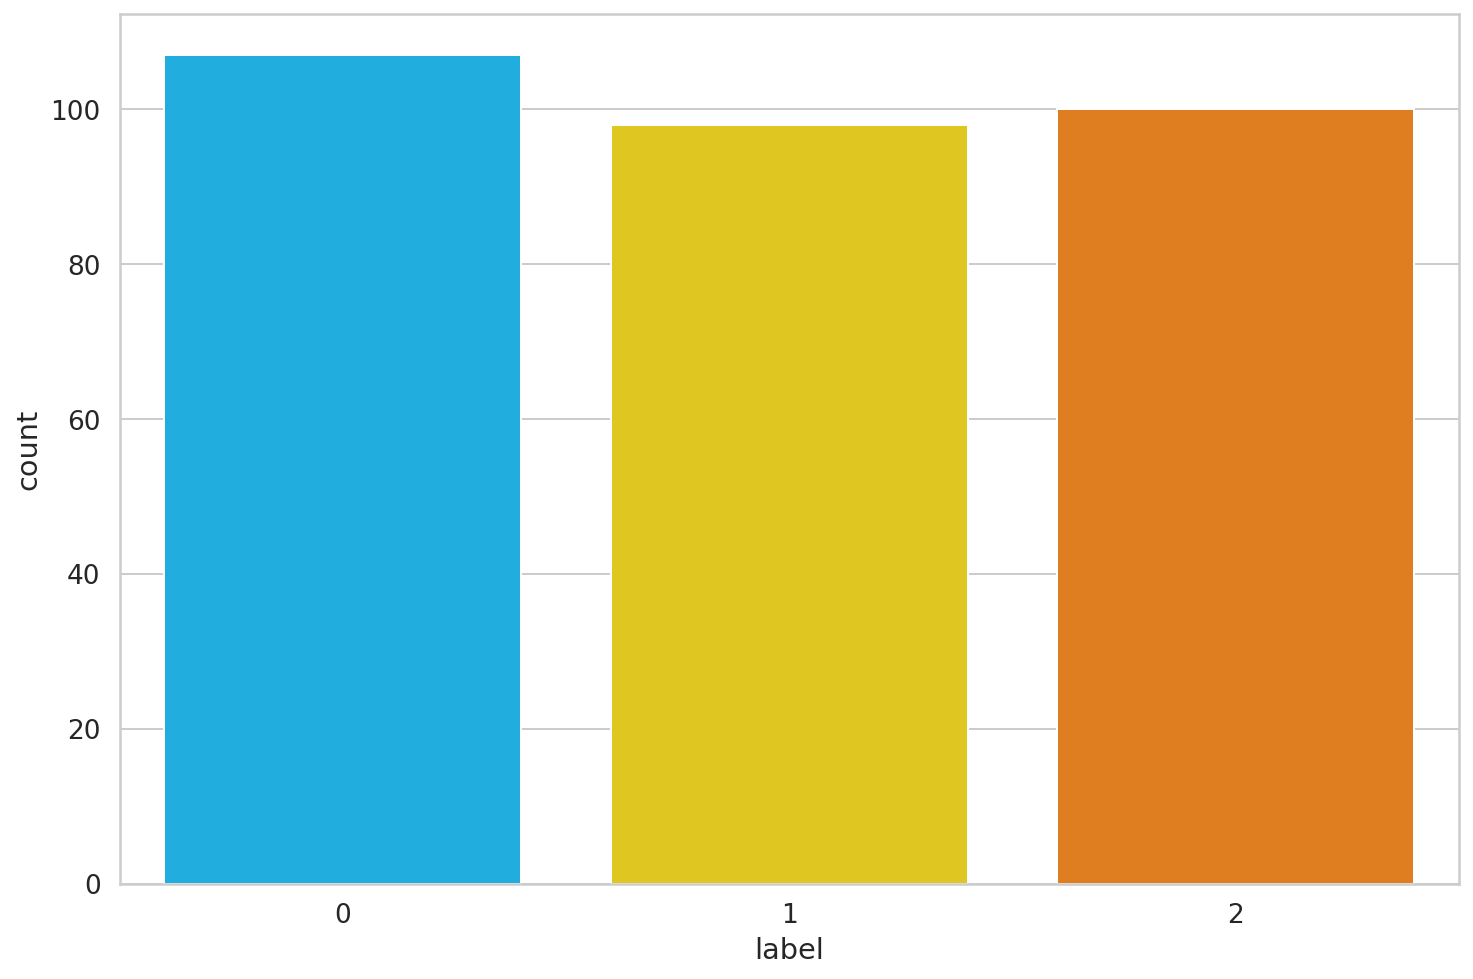

In [ ]:
sns.countplot(df.label)
plt.xlabel('label');

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))

encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))

encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []

for txt in df.sentence:

  tokens = tokenizer.encode(txt, max_length=512)

  token_lens.append(len(tokens))

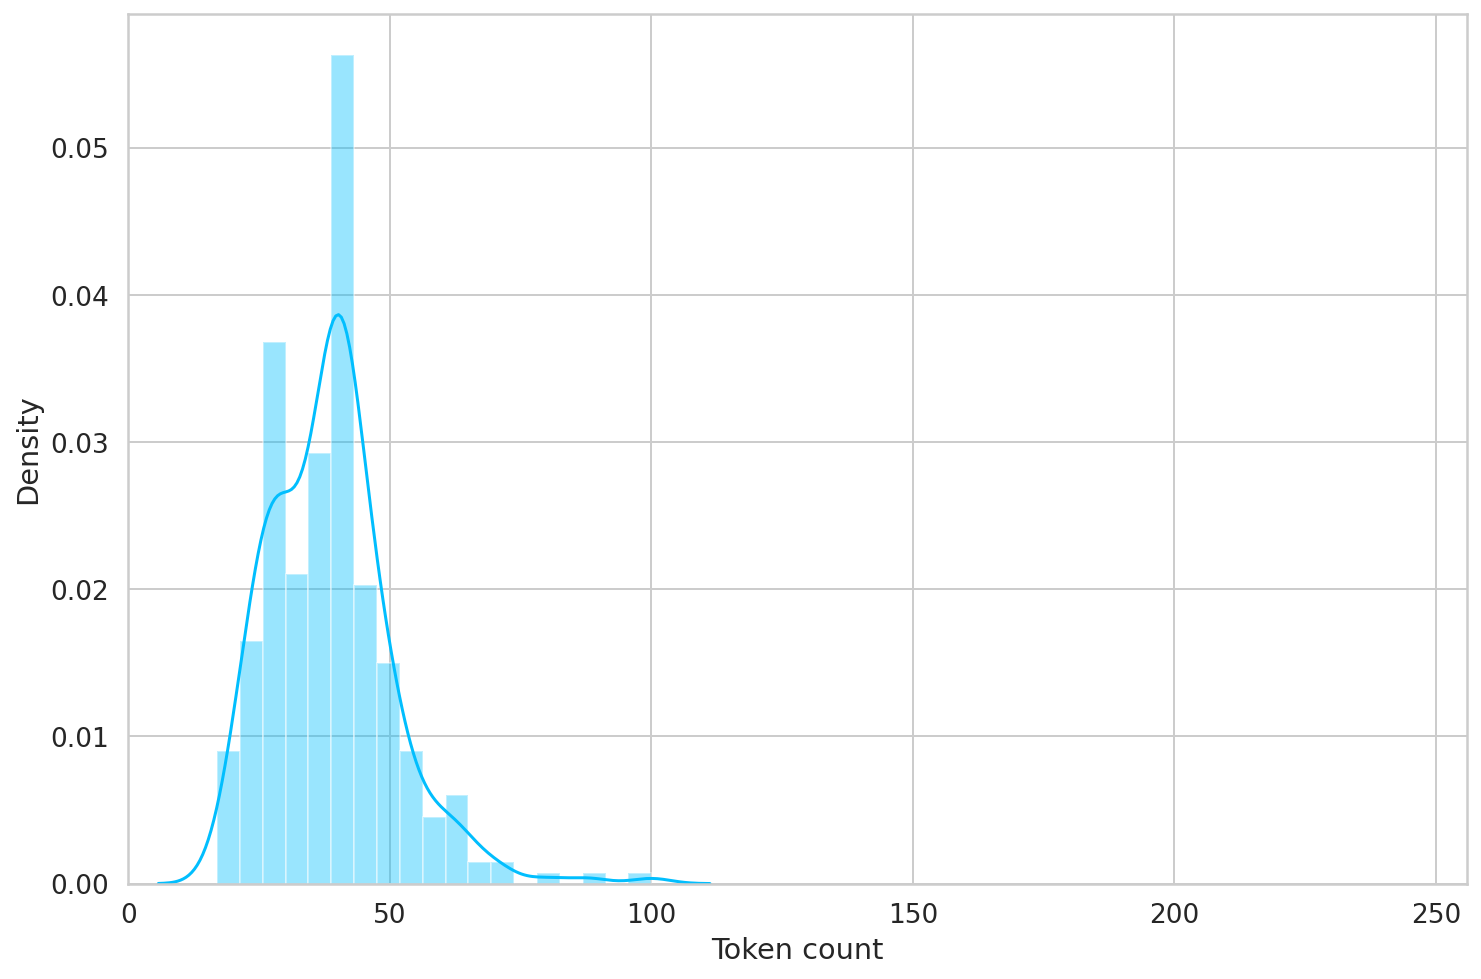

In [ ]:
sns.distplot(token_lens)

plt.xlim([0, 256]);

plt.xlabel('Token count');

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, sentence, label, tokenizer, max_len):

    self.sentence = sentence

    self.label = label

    self.tokenizer = tokenizer

    self.max_len = max_len

  def __len__(self):

    return len(self.sentence)

  def __getitem__(self, item):

    sentence = str(self.sentence[item])

    label = self.label[item]

    encoding = self.tokenizer.encode_plus(

      sentence,

      add_special_tokens=True,

      max_length=self.max_len,

      return_token_type_ids=False,

      pad_to_max_length=True,

      return_attention_mask=True,

      return_tensors='pt',

    )

    return {

      'sentence': sentence,

      'input_ids': encoding['input_ids'].flatten(),

      'attention_mask': encoding['attention_mask'].flatten(),

      'label': torch.tensor(label, dtype=torch.long)

    }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED

)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((259, 2), (23, 2), (23, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(

    sentence=df.sentence.to_numpy(),

    label=df.label.to_numpy(),

    tokenizer=tokenizer,

    max_len=max_len

  )

  return DataLoader(

    ds,

    batch_size=batch_size,

    num_workers=4

  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

data.keys()

dict_keys(['sentence', 'input_ids', 'attention_mask', 'label'])

In [ ]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['label'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = bert_model(

  input_ids=encoding['input_ids'],

  attention_mask=encoding['attention_mask']

)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class EP(nn.Module):

  def __init__(self, n_classes):

    super(EP, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p=0.1)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    output = self.drop(pooled_output)

    return self.out(output)

In [ ]:
model = EP(2)

model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length

print(attention_mask.shape)

torch.Size([32, 100])
torch.Size([32, 100])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1958, 0.4263, 0.3779],
        [0.2329, 0.3490, 0.4181],
        [0.2233, 0.3982, 0.3785],
        [0.1976, 0.3838, 0.4186],
        [0.3894, 0.2414, 0.3692],
        [0.2648, 0.2817, 0.4535],
        [0.2501, 0.3491, 0.4008],
        [0.2753, 0.3122, 0.4125],
        [0.3122, 0.2664, 0.4214],
        [0.2497, 0.3286, 0.4217],
        [0.2672, 0.3295, 0.4033],
        [0.2305, 0.3091, 0.4604],
        [0.2378, 0.4082, 0.3540],
        [0.2877, 0.2602, 0.4521],
        [0.2830, 0.3427, 0.3743],
        [0.2396, 0.3154, 0.4450],
        [0.2135, 0.3892, 0.3973],
        [0.2837, 0.2364, 0.4799],
        [0.2247, 0.4290, 0.3463],
        [0.2402, 0.3865, 0.3733],
        [0.3098, 0.2456, 0.4445],
        [0.3052, 0.2779, 0.4169],
        [0.2165, 0.4051, 0.3784],
        [0.2369, 0.2947, 0.4684],
        [0.2808, 0.2526, 0.4667],
        [0.2381, 0.3290, 0.4329],
        [0.2780, 0.3081, 0.4139],
        [0.1765, 0.3626, 0.4609],
        [0.3004, 0.3170, 0.3826],
        [0.248

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr= 2e-5, correct_bias=True)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(

  optimizer,

  num_warmup_steps=0,

  num_training_steps=total_steps

)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(

  model,

  data_loader,

  loss_fn,

  optimizer,

  device,

  scheduler,

  n_examples

):

  model = model.train()

  losses = []

  correct_predictions = 0

  for d in data_loader:

    input_ids = d["input_ids"].to(device)

    attention_mask = d["attention_mask"].to(device)

    targets = d["label"].to(device)

    outputs = model(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []

  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)

      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')

  print('-' * 10)

  train_acc, train_loss = train_epoch(

    model,

    train_data_loader,

    loss_fn,

    optimizer,

    device,

    scheduler,

    len(df_train)

  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(

    model,

    val_data_loader,

    loss_fn,

    device,

    len(df_val)

  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc.item())

  history['train_loss'].append(train_loss.item())

  history['val_acc'].append(val_acc.item())

  history['val_loss'].append(val_loss.item())

  if val_acc > best_accuracy:

    torch.save(model.state_dict(), 'best_model_state.bin')

    best_accuracy = val_acc



Epoch 1/10
----------
Train loss 1.1195089022318523 accuracy 0.35135135135135137
Val   loss 1.0597426891326904 accuracy 0.3913043478260869

Epoch 2/10
----------
Train loss 1.0368821687168546 accuracy 0.41312741312741313
Val   loss 0.9999704957008362 accuracy 0.5217391304347826

Epoch 3/10
----------
Train loss 0.9711148738861084 accuracy 0.5405405405405406
Val   loss 0.9646905660629272 accuracy 0.4782608695652174

Epoch 4/10
----------
Train loss 0.9210661384794447 accuracy 0.5945945945945946
Val   loss 0.9159365296363831 accuracy 0.5652173913043478

Epoch 5/10
----------
Train loss 0.8390331665674845 accuracy 0.7065637065637066
Val   loss 0.8410506844520569 accuracy 0.6956521739130435

Epoch 6/10
----------
Train loss 0.7652023037274679 accuracy 0.7413127413127414
Val   loss 0.7876224517822266 accuracy 0.7391304347826086

Epoch 7/10
----------
Train loss 0.6665192478232913 accuracy 0.8455598455598455
Val   loss 0.7255685925483704 accuracy 0.8260869565217391

Epoch 8/10
----------
Tra

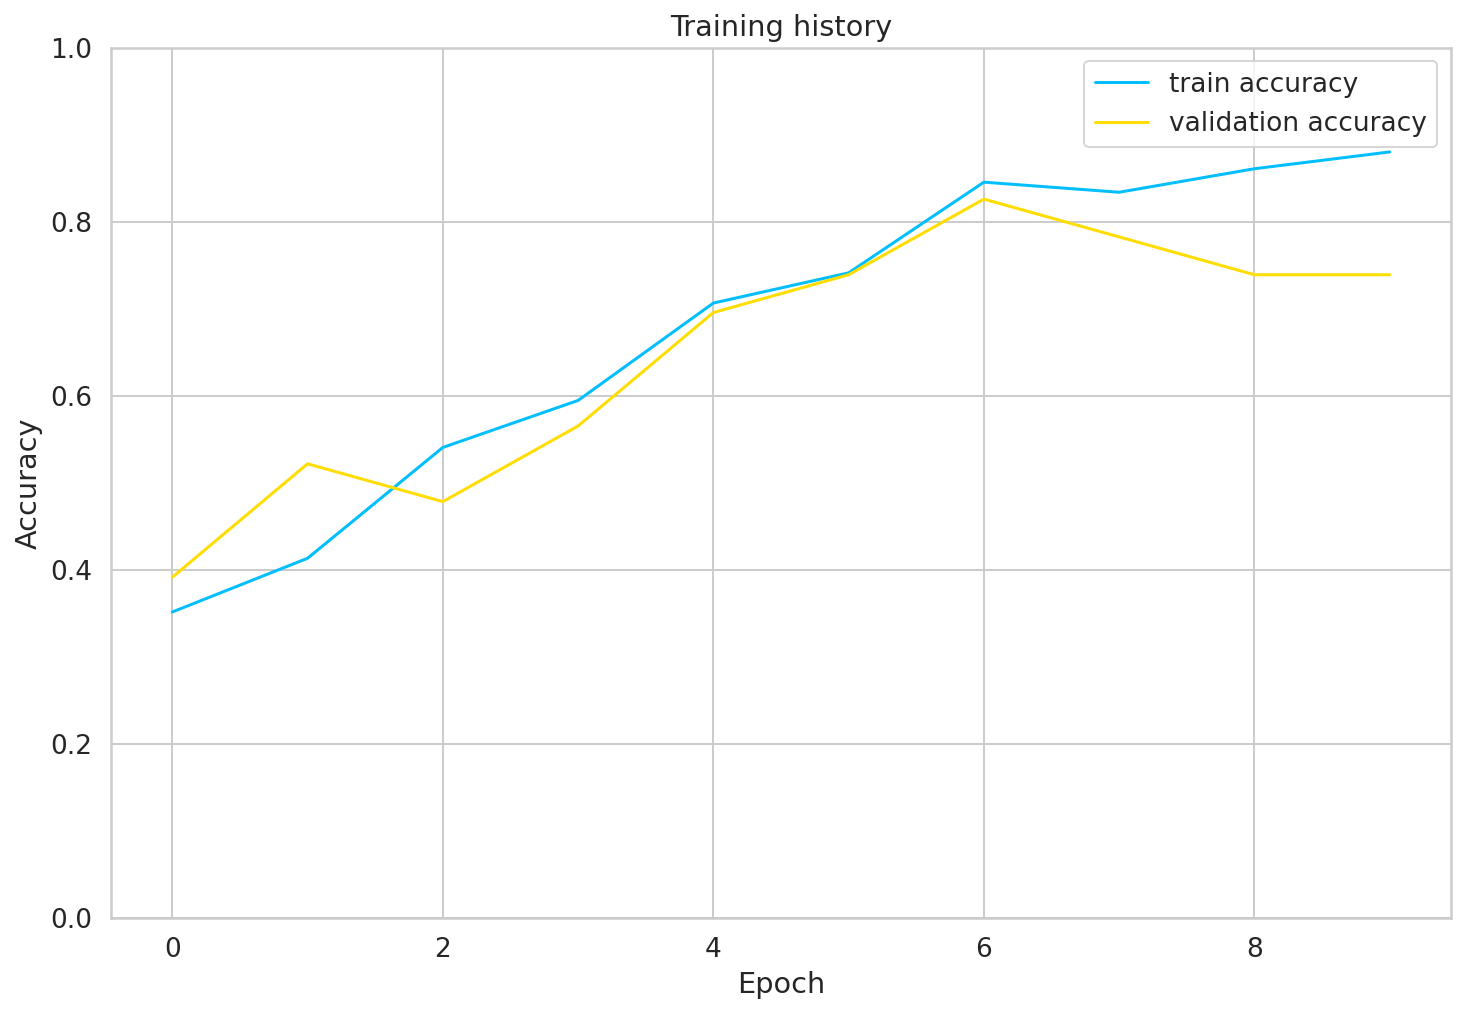

In [ ]:


plt.plot(history['train_acc'], label='train accuracy')

plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [ ]:
val_acc, _ = eval_model(

  model,

  val_data_loader,

  loss_fn,

  device,

  len(df_val)

)
val_acc.item()

0.7391304347826086

In [ ]:
test_acc, _ = eval_model(

  model,

  test_data_loader,

  loss_fn,

  device,

  len(df_test)

)

In [ ]:

test_acc.item()

0.7391304347826086

In [ ]:
def get_predictions(model, data_loader):

  model = model.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d["sentence"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)

      predictions.extend(preds)

      prediction_probs.extend(outputs)

      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred_model_1, y_pred_probs, y_test = get_predictions(

  model,

  test_data_loader

)

In [ ]:
print(classification_report(y_test, y_pred_model_1, target_names=['enable', 'none']))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.86      0.75      0.80         8
           2       0.60      0.50      0.55         6

    accuracy                           0.74        23
   macro avg       0.73      0.71      0.72        23
weighted avg       0.74      0.74      0.73        23



In [ ]:
for i in range(len(y_review_texts)):
    print('Text: ' + y_review_texts[i], '\nActual Label: ' + str(y_test[i].item()), '\nPredicted Label: ' + str(y_pred_model_1[i].item()), '\n\n')

Text: Through a strategic collaboration, AWS and Deloitte empower customers to transform their business and innovate faster by combining AWS technologies with Deloitte's deep industry experience. 
Actual Label: 0 
Predicted Label: 0 


Text: For 15 years, BIO KOREA has been a place of bringing together various international academics, professionals, and CEOs of global bio companies to obtain, exchange, and discuss diverse affairs. 
Actual Label: 2 
Predicted Label: 2 


Text:    Bryan, Garnier & Co is a European, full-service growth-focused independent investment banking partnership founded in 1996. 
Actual Label: 2 
Predicted Label: 0 


Text: Migrant workers in Lebanon have been hit hard by its multiple crises and half of them left jobless, the UN warned Wednesday, calling for voluntary returns to be scaled up. 
Actual Label: 0 
Predicted Label: 1 


Text: The following day he may have the perfect present in Manchester City's first Champions League crown. 
Actual Label: 2 
Predicted 

In [ ]:
pd.set_option('max_rows', 99999)
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
5,The Sandbox includes access to Temenos Banking...,0
6,"Among individual companies, Amazon edged up 0....",0
7,Migrant workers in Lebanon have been hit hard ...,0
8,Analysts greeted reports that Senate Republica...,0
9,This is the second time the fragmented centre-...,0


# Prevent and neutral sentences


In [ ]:
p_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/prevent_df.csv'))
p_df['label'] = 0
n_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/none_df.csv'), nrows=100)
n_df['label'] = 1
df = pd.concat([p_df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0', 'verb', 'trigger_1', 'trigger_2'], axis=1, inplace=True)


In [ ]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
300,Victoria had not recorded any locally acquired...,2
301,But repeated failures of the quarantine system...,2
302,"Australia -- which has recorded about 30,000 c...",2
303,New current affairs channel GB News on Wednesd...,2


In [ ]:
'''
df = pd.concat([df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
'''

"\ndf = pd.concat([df, n_df], ignore_index=True, sort=False)\ndf.drop(['Unnamed: 0'], axis=1, inplace=True)\n"

In [ ]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
300,Victoria had not recorded any locally acquired...,2
301,But repeated failures of the quarantine system...,2
302,"Australia -- which has recorded about 30,000 c...",2
303,New current affairs channel GB News on Wednesd...,2


In [ ]:
df.shape

(305, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  305 non-null    object
 1   label     305 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


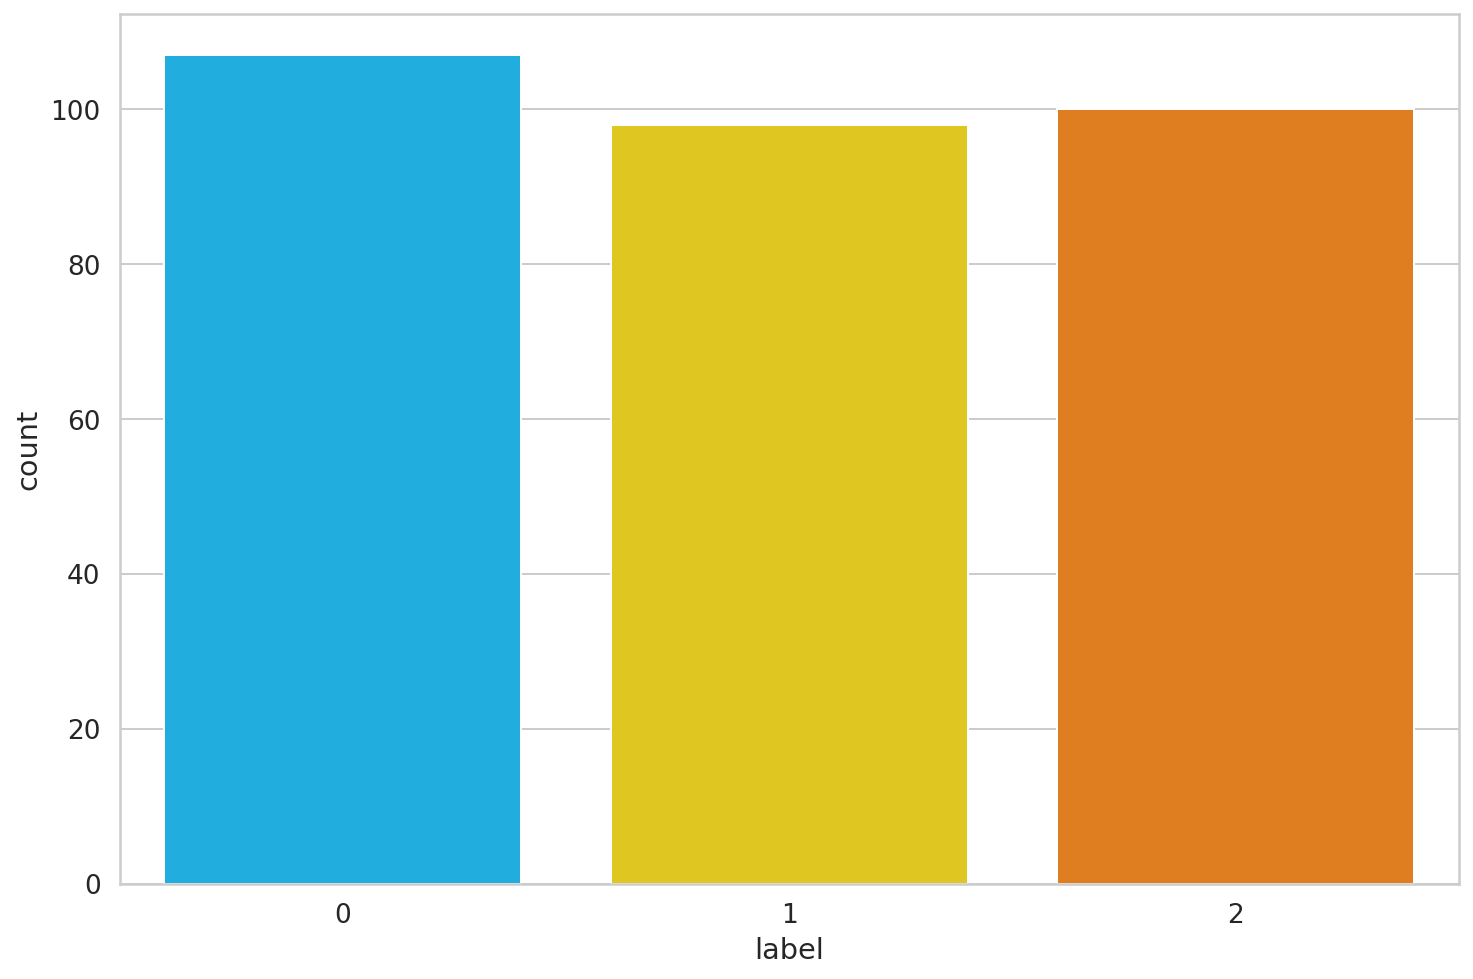

In [ ]:
sns.countplot(df.label)
plt.xlabel('label');

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))

encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))

encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []

for txt in df.sentence:

  tokens = tokenizer.encode(txt, max_length=512)

  token_lens.append(len(tokens))

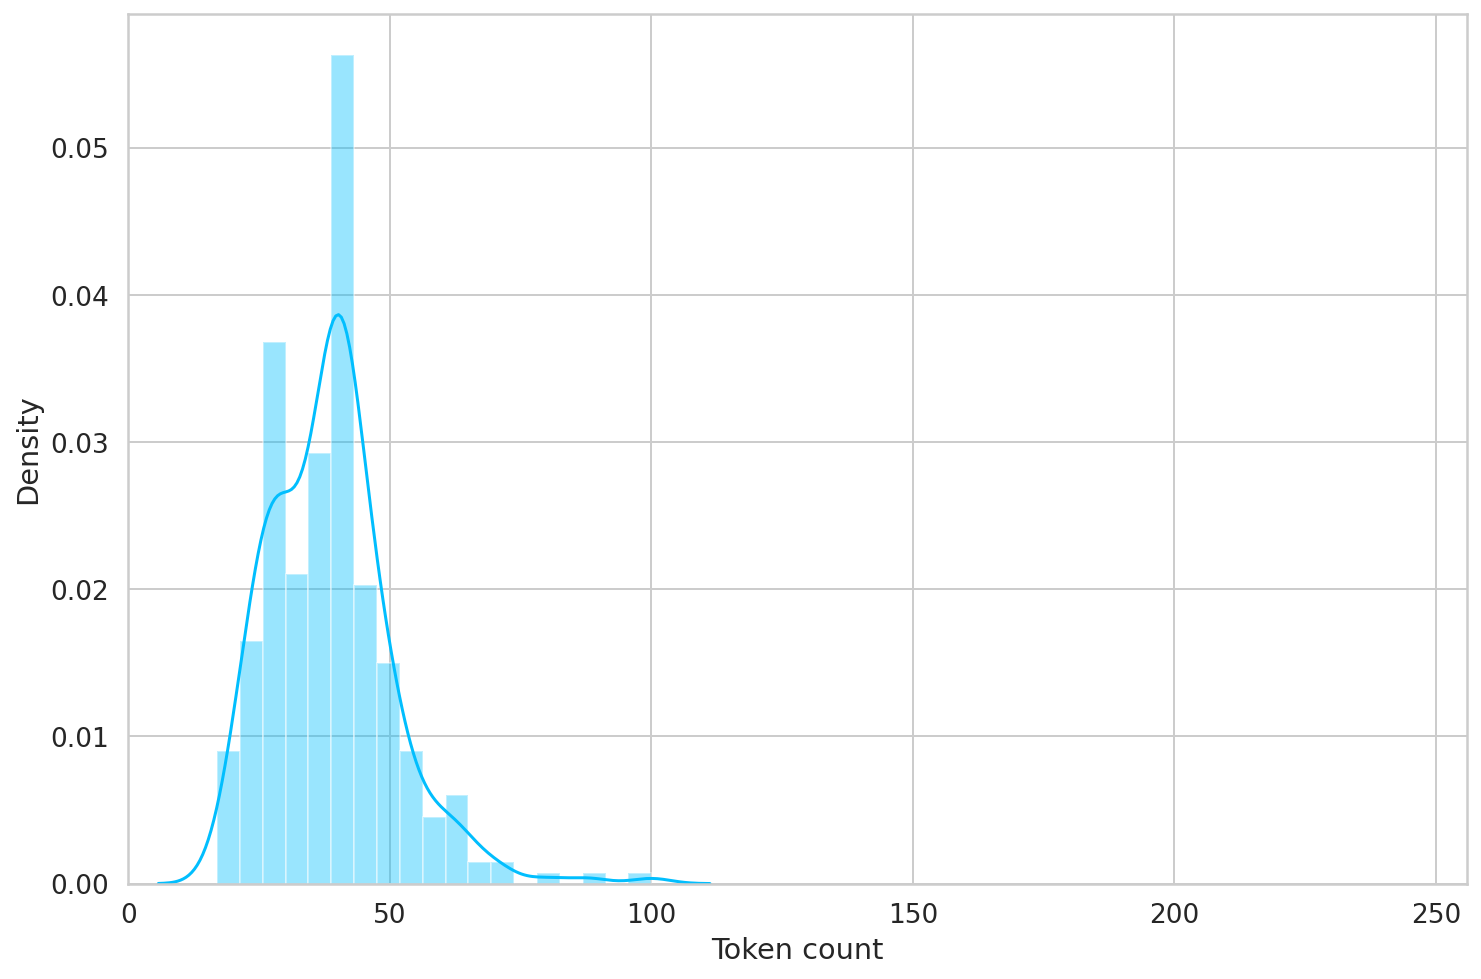

In [ ]:
sns.distplot(token_lens)

plt.xlim([0, 256]);

plt.xlabel('Token count');

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, sentence, label, tokenizer, max_len):

    self.sentence = sentence

    self.label = label

    self.tokenizer = tokenizer

    self.max_len = max_len

  def __len__(self):

    return len(self.sentence)

  def __getitem__(self, item):

    sentence = str(self.sentence[item])

    label = self.label[item]

    encoding = self.tokenizer.encode_plus(

      sentence,

      add_special_tokens=True,

      max_length=self.max_len,

      return_token_type_ids=False,

      pad_to_max_length=True,

      return_attention_mask=True,

      return_tensors='pt',

    )

    return {

      'sentence': sentence,

      'input_ids': encoding['input_ids'].flatten(),

      'attention_mask': encoding['attention_mask'].flatten(),

      'label': torch.tensor(label, dtype=torch.long)

    }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED

)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((259, 2), (23, 2), (23, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(

    sentence=df.sentence.to_numpy(),

    label=df.label.to_numpy(),

    tokenizer=tokenizer,

    max_len=max_len

  )

  return DataLoader(

    ds,

    batch_size=batch_size,

    num_workers=4

  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

data.keys()

dict_keys(['sentence', 'input_ids', 'attention_mask', 'label'])

In [ ]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['label'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = bert_model(

  input_ids=encoding['input_ids'],

  attention_mask=encoding['attention_mask']

)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class EP(nn.Module):

  def __init__(self, n_classes):

    super(EP, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p=0.1)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    output = self.drop(pooled_output)

    return self.out(output)

In [ ]:
model = EP(2)

model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length

print(attention_mask.shape)

torch.Size([32, 100])
torch.Size([32, 100])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1958, 0.4263, 0.3779],
        [0.2329, 0.3490, 0.4181],
        [0.2233, 0.3982, 0.3785],
        [0.1976, 0.3838, 0.4186],
        [0.3894, 0.2414, 0.3692],
        [0.2648, 0.2817, 0.4535],
        [0.2501, 0.3491, 0.4008],
        [0.2753, 0.3122, 0.4125],
        [0.3122, 0.2664, 0.4214],
        [0.2497, 0.3286, 0.4217],
        [0.2672, 0.3295, 0.4033],
        [0.2305, 0.3091, 0.4604],
        [0.2378, 0.4082, 0.3540],
        [0.2877, 0.2602, 0.4521],
        [0.2830, 0.3427, 0.3743],
        [0.2396, 0.3154, 0.4450],
        [0.2135, 0.3892, 0.3973],
        [0.2837, 0.2364, 0.4799],
        [0.2247, 0.4290, 0.3463],
        [0.2402, 0.3865, 0.3733],
        [0.3098, 0.2456, 0.4445],
        [0.3052, 0.2779, 0.4169],
        [0.2165, 0.4051, 0.3784],
        [0.2369, 0.2947, 0.4684],
        [0.2808, 0.2526, 0.4667],
        [0.2381, 0.3290, 0.4329],
        [0.2780, 0.3081, 0.4139],
        [0.1765, 0.3626, 0.4609],
        [0.3004, 0.3170, 0.3826],
        [0.248

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr= 2e-5, correct_bias=True)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(

  optimizer,

  num_warmup_steps=0,

  num_training_steps=total_steps

)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(

  model,

  data_loader,

  loss_fn,

  optimizer,

  device,

  scheduler,

  n_examples

):

  model = model.train()

  losses = []

  correct_predictions = 0

  for d in data_loader:

    input_ids = d["input_ids"].to(device)

    attention_mask = d["attention_mask"].to(device)

    targets = d["label"].to(device)

    outputs = model(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []

  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)

      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')

  print('-' * 10)

  train_acc, train_loss = train_epoch(

    model,

    train_data_loader,

    loss_fn,

    optimizer,

    device,

    scheduler,

    len(df_train)

  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(

    model,

    val_data_loader,

    loss_fn,

    device,

    len(df_val)

  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc.item())

  history['train_loss'].append(train_loss.item())

  history['val_acc'].append(val_acc.item())

  history['val_loss'].append(val_loss.item())

  if val_acc > best_accuracy:

    torch.save(model.state_dict(), 'best_model_state.bin')

    best_accuracy = val_acc



Epoch 1/10
----------
Train loss 1.1195089022318523 accuracy 0.35135135135135137
Val   loss 1.0597426891326904 accuracy 0.3913043478260869

Epoch 2/10
----------
Train loss 1.0368821687168546 accuracy 0.41312741312741313
Val   loss 0.9999704957008362 accuracy 0.5217391304347826

Epoch 3/10
----------
Train loss 0.9711148738861084 accuracy 0.5405405405405406
Val   loss 0.9646905660629272 accuracy 0.4782608695652174

Epoch 4/10
----------
Train loss 0.9210661384794447 accuracy 0.5945945945945946
Val   loss 0.9159365296363831 accuracy 0.5652173913043478

Epoch 5/10
----------
Train loss 0.8390331665674845 accuracy 0.7065637065637066
Val   loss 0.8410506844520569 accuracy 0.6956521739130435

Epoch 6/10
----------
Train loss 0.7652023037274679 accuracy 0.7413127413127414
Val   loss 0.7876224517822266 accuracy 0.7391304347826086

Epoch 7/10
----------
Train loss 0.6665192478232913 accuracy 0.8455598455598455
Val   loss 0.7255685925483704 accuracy 0.8260869565217391

Epoch 8/10
----------
Tra

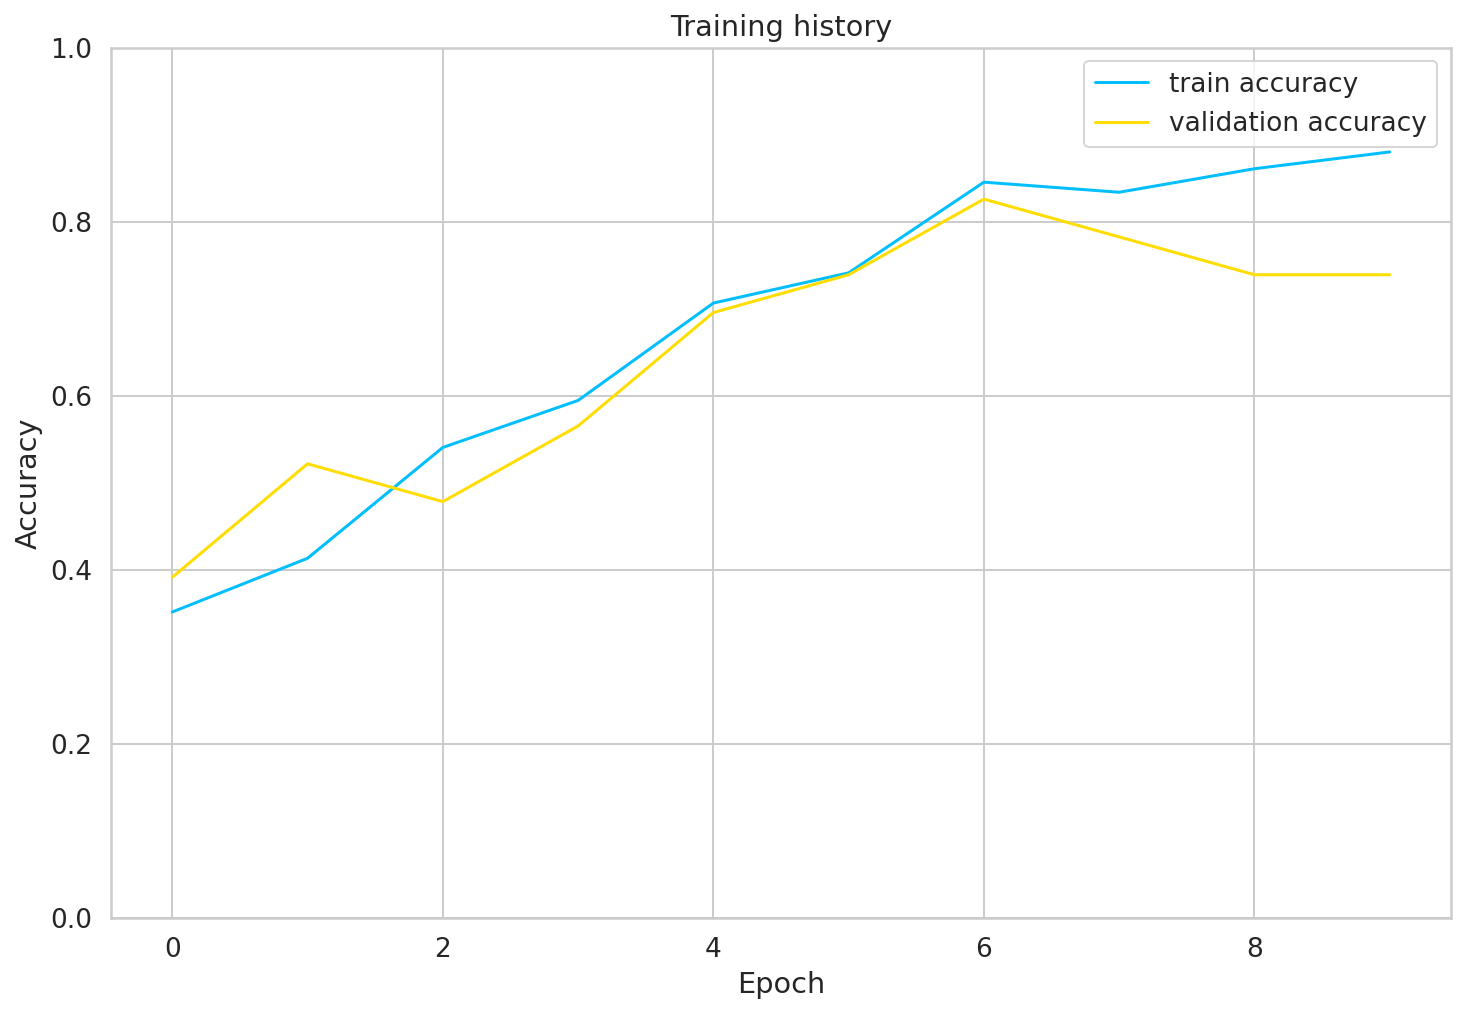

In [ ]:


plt.plot(history['train_acc'], label='train accuracy')

plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [ ]:
val_acc, _ = eval_model(

  model,

  val_data_loader,

  loss_fn,

  device,

  len(df_val)

)
val_acc.item()

0.7391304347826086

In [ ]:
test_acc, _ = eval_model(

  model,

  test_data_loader,

  loss_fn,

  device,

  len(df_test)

)

In [ ]:

test_acc.item()

0.7391304347826086

In [ ]:
def get_predictions(model, data_loader):

  model = model.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d["sentence"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)

      predictions.extend(preds)

      prediction_probs.extend(outputs)

      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred_model_1, y_pred_probs, y_test = get_predictions(

  model,

  test_data_loader

)

In [ ]:
print(classification_report(y_test, y_pred_model_1, target_names=['prevent', 'none']))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.86      0.75      0.80         8
           2       0.60      0.50      0.55         6

    accuracy                           0.74        23
   macro avg       0.73      0.71      0.72        23
weighted avg       0.74      0.74      0.73        23



In [ ]:
for i in range(len(y_review_texts)):
    print('Text: ' + y_review_texts[i], '\nActual Label: ' + str(y_test[i].item()), '\nPredicted Label: ' + str(y_pred_model_1[i].item()), '\n\n')

Text: Through a strategic collaboration, AWS and Deloitte empower customers to transform their business and innovate faster by combining AWS technologies with Deloitte's deep industry experience. 
Actual Label: 0 
Predicted Label: 0 


Text: For 15 years, BIO KOREA has been a place of bringing together various international academics, professionals, and CEOs of global bio companies to obtain, exchange, and discuss diverse affairs. 
Actual Label: 2 
Predicted Label: 2 


Text:    Bryan, Garnier & Co is a European, full-service growth-focused independent investment banking partnership founded in 1996. 
Actual Label: 2 
Predicted Label: 0 


Text: Migrant workers in Lebanon have been hit hard by its multiple crises and half of them left jobless, the UN warned Wednesday, calling for voluntary returns to be scaled up. 
Actual Label: 0 
Predicted Label: 1 


Text: The following day he may have the perfect present in Manchester City's first Champions League crown. 
Actual Label: 2 
Predicted 

In [ ]:
pd.set_option('max_rows', 99999)
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
5,The Sandbox includes access to Temenos Banking...,0
6,"Among individual companies, Amazon edged up 0....",0
7,Migrant workers in Lebanon have been hit hard ...,0
8,Analysts greeted reports that Senate Republica...,0
9,This is the second time the fragmented centre-...,0


# Enable, Prevent and neutral sentences **(3 Way classification)**
 

In [131]:
e_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/enable_df.csv'))
e_df['label'] = 0
p_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/prevent_df.csv'))
p_df['label'] = 1
n_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/none_df.csv'), nrows=100)
n_df['label'] = 2
df = pd.concat([e_df, p_df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0', 'verb', 'trigger_1', 'trigger_2'], axis=1, inplace=True)


In [132]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
300,Victoria had not recorded any locally acquired...,2
301,But repeated failures of the quarantine system...,2
302,"Australia -- which has recorded about 30,000 c...",2
303,New current affairs channel GB News on Wednesd...,2


In [133]:
'''
df = pd.concat([df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
'''

"\ndf = pd.concat([df, n_df], ignore_index=True, sort=False)\ndf.drop(['Unnamed: 0'], axis=1, inplace=True)\n"

In [134]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
300,Victoria had not recorded any locally acquired...,2
301,But repeated failures of the quarantine system...,2
302,"Australia -- which has recorded about 30,000 c...",2
303,New current affairs channel GB News on Wednesd...,2


In [135]:
df.shape

(305, 2)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  305 non-null    object
 1   label     305 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


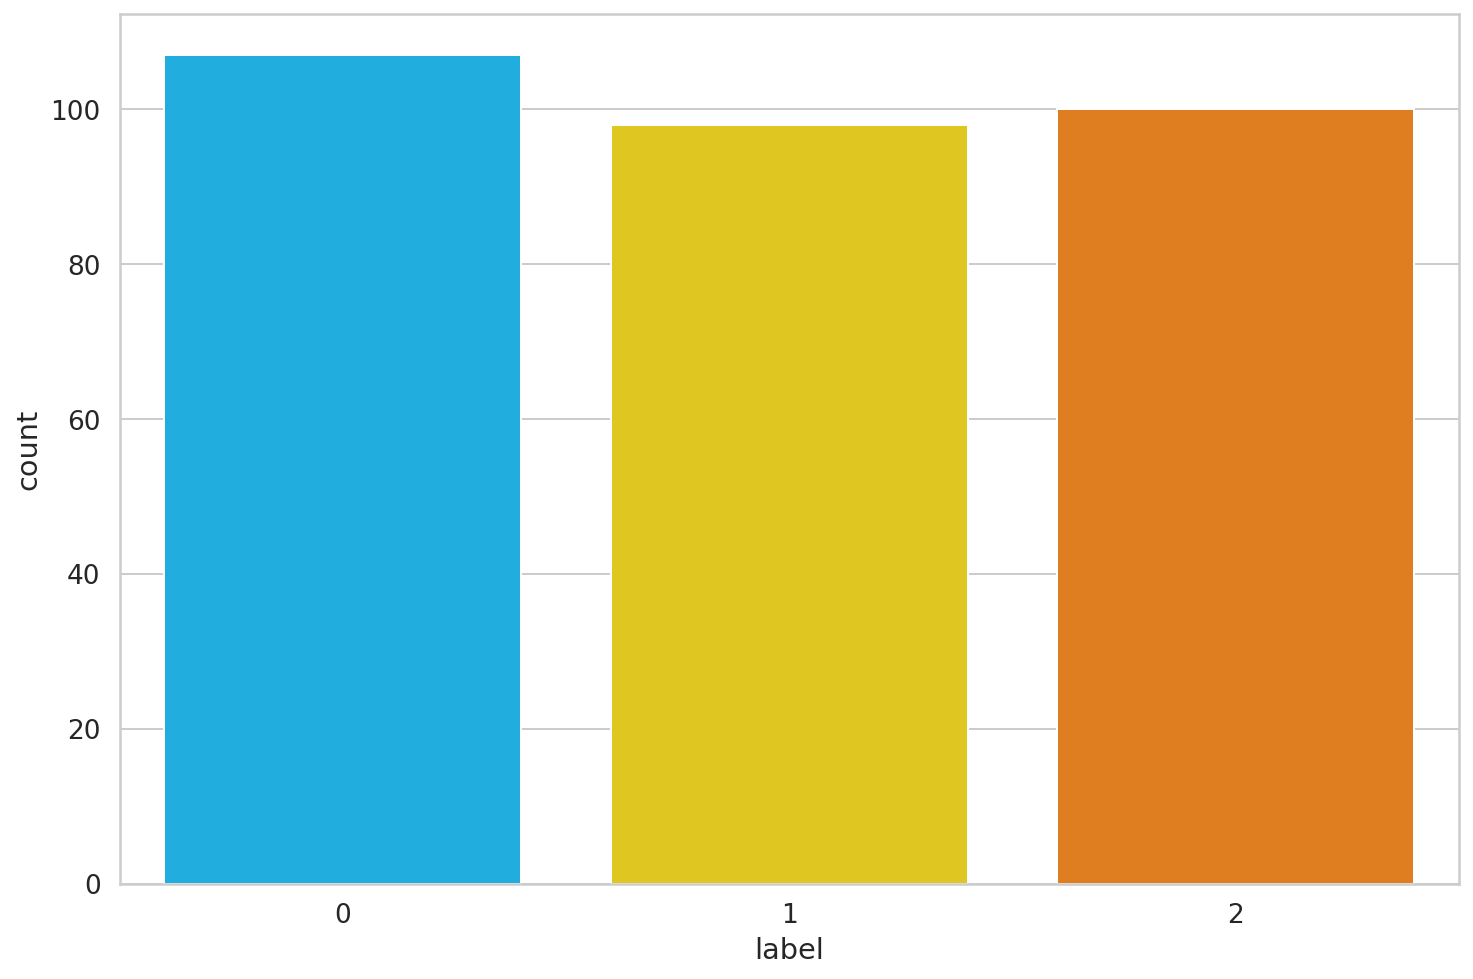

In [137]:
sns.countplot(df.label)
plt.xlabel('label');

In [138]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [139]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [140]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [141]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [142]:
print(len(encoding['input_ids'][0]))

encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [143]:
print(len(encoding['attention_mask'][0]))

encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [144]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [145]:
token_lens = []

for txt in df.sentence:

  tokens = tokenizer.encode(txt, max_length=512)

  token_lens.append(len(tokens))

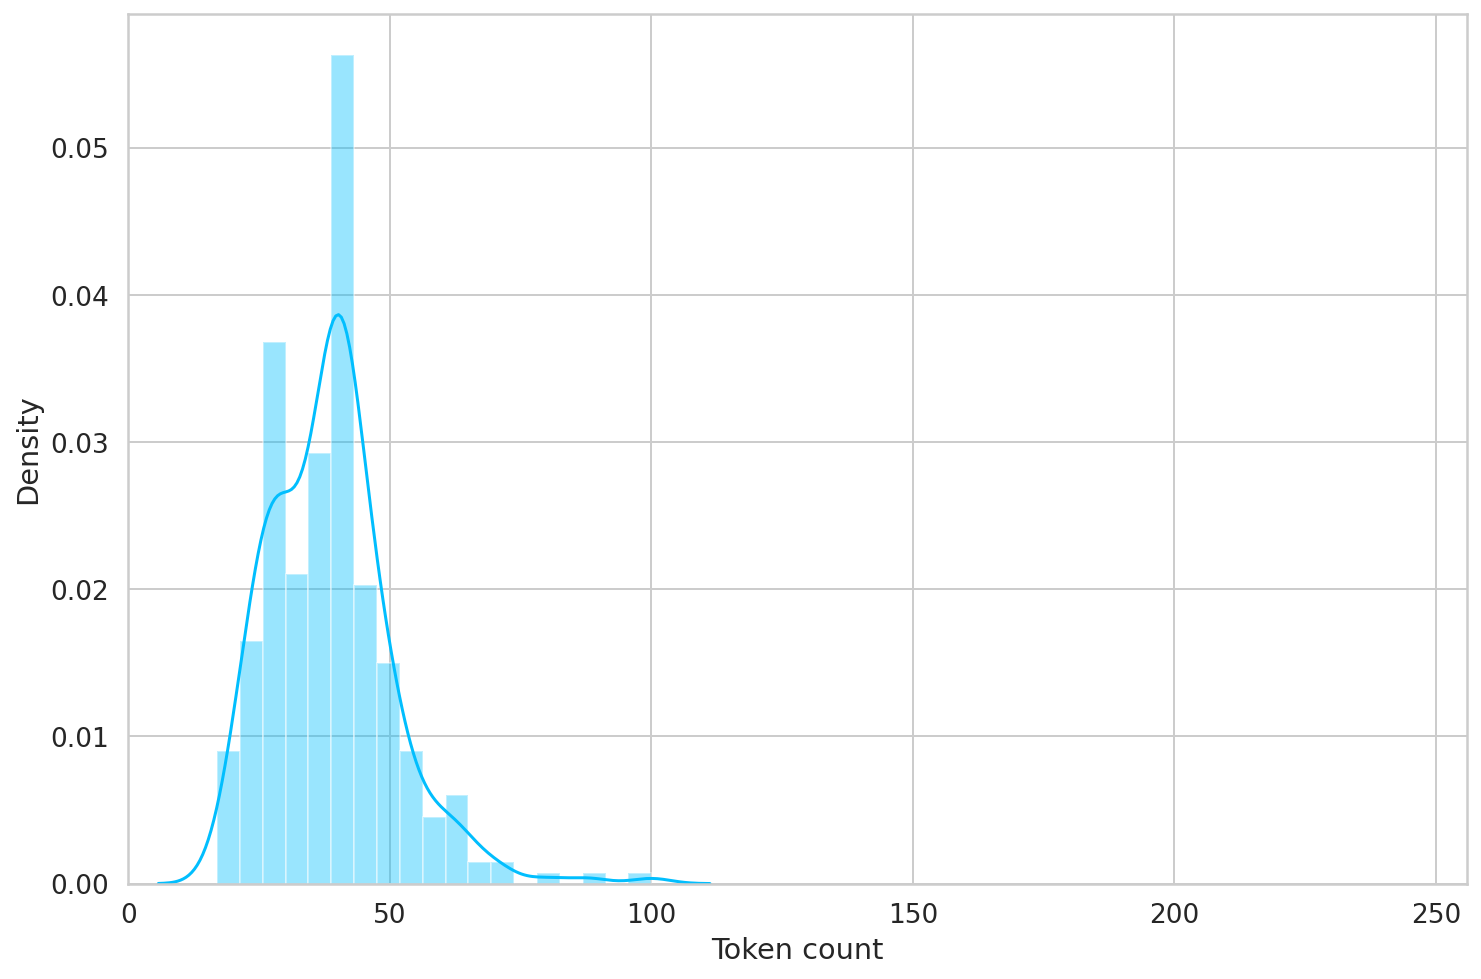

In [146]:
sns.distplot(token_lens)

plt.xlim([0, 256]);

plt.xlabel('Token count');

In [147]:
MAX_LEN = 100

In [148]:
class GPReviewDataset(Dataset):

  def __init__(self, sentence, label, tokenizer, max_len):

    self.sentence = sentence

    self.label = label

    self.tokenizer = tokenizer

    self.max_len = max_len

  def __len__(self):

    return len(self.sentence)

  def __getitem__(self, item):

    sentence = str(self.sentence[item])

    label = self.label[item]

    encoding = self.tokenizer.encode_plus(

      sentence,

      add_special_tokens=True,

      max_length=self.max_len,

      return_token_type_ids=False,

      pad_to_max_length=True,

      return_attention_mask=True,

      return_tensors='pt',

    )

    return {

      'sentence': sentence,

      'input_ids': encoding['input_ids'].flatten(),

      'attention_mask': encoding['attention_mask'].flatten(),

      'label': torch.tensor(label, dtype=torch.long)

    }

In [149]:
df_train, df_test = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED

)

In [150]:
df_train.shape, df_val.shape, df_test.shape

((259, 2), (23, 2), (23, 2))

In [151]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(

    sentence=df.sentence.to_numpy(),

    label=df.label.to_numpy(),

    tokenizer=tokenizer,

    max_len=max_len

  )

  return DataLoader(

    ds,

    batch_size=batch_size,

    num_workers=4

  )

In [152]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

data.keys()

dict_keys(['sentence', 'input_ids', 'attention_mask', 'label'])

In [ ]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['label'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = bert_model(

  input_ids=encoding['input_ids'],

  attention_mask=encoding['attention_mask']

)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class EP(nn.Module):

  def __init__(self, n_classes):

    super(EP, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p=0.1)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    output = self.drop(pooled_output)

    return self.out(output)

In [ ]:
model = EP(3)

model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length

print(attention_mask.shape)

torch.Size([32, 100])
torch.Size([32, 100])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1958, 0.4263, 0.3779],
        [0.2329, 0.3490, 0.4181],
        [0.2233, 0.3982, 0.3785],
        [0.1976, 0.3838, 0.4186],
        [0.3894, 0.2414, 0.3692],
        [0.2648, 0.2817, 0.4535],
        [0.2501, 0.3491, 0.4008],
        [0.2753, 0.3122, 0.4125],
        [0.3122, 0.2664, 0.4214],
        [0.2497, 0.3286, 0.4217],
        [0.2672, 0.3295, 0.4033],
        [0.2305, 0.3091, 0.4604],
        [0.2378, 0.4082, 0.3540],
        [0.2877, 0.2602, 0.4521],
        [0.2830, 0.3427, 0.3743],
        [0.2396, 0.3154, 0.4450],
        [0.2135, 0.3892, 0.3973],
        [0.2837, 0.2364, 0.4799],
        [0.2247, 0.4290, 0.3463],
        [0.2402, 0.3865, 0.3733],
        [0.3098, 0.2456, 0.4445],
        [0.3052, 0.2779, 0.4169],
        [0.2165, 0.4051, 0.3784],
        [0.2369, 0.2947, 0.4684],
        [0.2808, 0.2526, 0.4667],
        [0.2381, 0.3290, 0.4329],
        [0.2780, 0.3081, 0.4139],
        [0.1765, 0.3626, 0.4609],
        [0.3004, 0.3170, 0.3826],
        [0.248

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr= 2e-5, correct_bias=True)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(

  optimizer,

  num_warmup_steps=0,

  num_training_steps=total_steps

)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(

  model,

  data_loader,

  loss_fn,

  optimizer,

  device,

  scheduler,

  n_examples

):

  model = model.train()

  losses = []

  correct_predictions = 0

  for d in data_loader:

    input_ids = d["input_ids"].to(device)

    attention_mask = d["attention_mask"].to(device)

    targets = d["label"].to(device)

    outputs = model(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []

  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)

      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')

  print('-' * 10)

  train_acc, train_loss = train_epoch(

    model,

    train_data_loader,

    loss_fn,

    optimizer,

    device,

    scheduler,

    len(df_train)

  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(

    model,

    val_data_loader,

    loss_fn,

    device,

    len(df_val)

  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc.item())

  history['train_loss'].append(train_loss.item())

  history['val_acc'].append(val_acc.item())

  history['val_loss'].append(val_loss.item())

  if val_acc > best_accuracy:

    torch.save(model.state_dict(), 'best_model_state.bin')

    best_accuracy = val_acc



Epoch 1/10
----------
Train loss 1.1195089022318523 accuracy 0.35135135135135137
Val   loss 1.0597426891326904 accuracy 0.3913043478260869

Epoch 2/10
----------
Train loss 1.0368821687168546 accuracy 0.41312741312741313
Val   loss 0.9999704957008362 accuracy 0.5217391304347826

Epoch 3/10
----------
Train loss 0.9711148738861084 accuracy 0.5405405405405406
Val   loss 0.9646905660629272 accuracy 0.4782608695652174

Epoch 4/10
----------
Train loss 0.9210661384794447 accuracy 0.5945945945945946
Val   loss 0.9159365296363831 accuracy 0.5652173913043478

Epoch 5/10
----------
Train loss 0.8390331665674845 accuracy 0.7065637065637066
Val   loss 0.8410506844520569 accuracy 0.6956521739130435

Epoch 6/10
----------
Train loss 0.7652023037274679 accuracy 0.7413127413127414
Val   loss 0.7876224517822266 accuracy 0.7391304347826086

Epoch 7/10
----------
Train loss 0.6665192478232913 accuracy 0.8455598455598455
Val   loss 0.7255685925483704 accuracy 0.8260869565217391

Epoch 8/10
----------
Tra

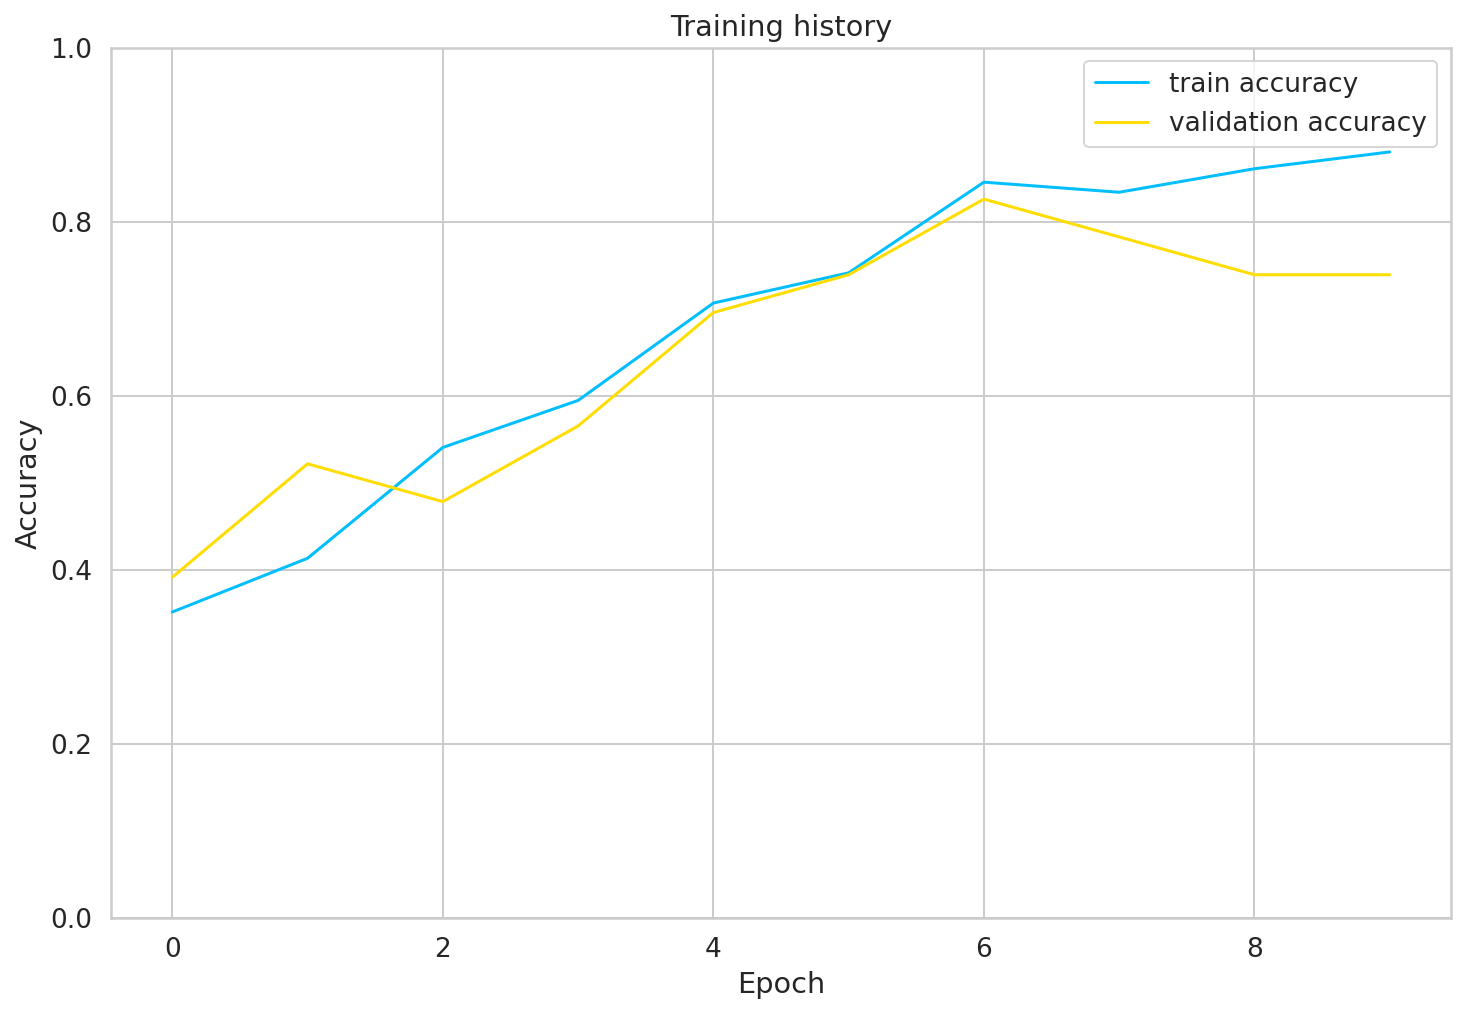

In [ ]:


plt.plot(history['train_acc'], label='train accuracy')

plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [ ]:
val_acc, _ = eval_model(

  model,

  val_data_loader,

  loss_fn,

  device,

  len(df_val)

)
val_acc.item()

0.7391304347826086

In [ ]:
test_acc, _ = eval_model(

  model,

  test_data_loader,

  loss_fn,

  device,

  len(df_test)

)

In [ ]:

test_acc.item()

0.7391304347826086

In [ ]:
def get_predictions(model, data_loader):

  model = model.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d["sentence"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)

      predictions.extend(preds)

      prediction_probs.extend(outputs)

      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred_model_1, y_pred_probs, y_test = get_predictions(

  model,

  test_data_loader

)

In [ ]:
print(classification_report(y_test, y_pred_model_1, target_names=['enable','prevent','none']))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.86      0.75      0.80         8
           2       0.60      0.50      0.55         6

    accuracy                           0.74        23
   macro avg       0.73      0.71      0.72        23
weighted avg       0.74      0.74      0.73        23



In [ ]:
for i in range(len(y_review_texts)):
    print('Text: ' + y_review_texts[i], '\nActual Label: ' + str(y_test[i].item()), '\nPredicted Label: ' + str(y_pred_model_1[i].item()), '\n\n')

Text: Through a strategic collaboration, AWS and Deloitte empower customers to transform their business and innovate faster by combining AWS technologies with Deloitte's deep industry experience. 
Actual Label: 0 
Predicted Label: 0 


Text: For 15 years, BIO KOREA has been a place of bringing together various international academics, professionals, and CEOs of global bio companies to obtain, exchange, and discuss diverse affairs. 
Actual Label: 2 
Predicted Label: 2 


Text:    Bryan, Garnier & Co is a European, full-service growth-focused independent investment banking partnership founded in 1996. 
Actual Label: 2 
Predicted Label: 0 


Text: Migrant workers in Lebanon have been hit hard by its multiple crises and half of them left jobless, the UN warned Wednesday, calling for voluntary returns to be scaled up. 
Actual Label: 0 
Predicted Label: 1 


Text: The following day he may have the perfect present in Manchester City's first Champions League crown. 
Actual Label: 2 
Predicted 

In [ ]:
pd.set_option('max_rows', 99999)
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
5,The Sandbox includes access to Temenos Banking...,0
6,"Among individual companies, Amazon edged up 0....",0
7,Migrant workers in Lebanon have been hit hard ...,0
8,Analysts greeted reports that Senate Republica...,0
9,This is the second time the fragmented centre-...,0


# Enable and Prevent with Majority voting ensemble

## Prevent And Enable models

### Enable vs None Model

In [44]:
e_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/enable_df.csv'))
e_df['label'] = 0
n_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/none_df.csv'), nrows=100)
n_df['label'] = 1
df = pd.concat([e_df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0', 'verb', 'trigger_1', 'trigger_2'], axis=1, inplace=True)


In [45]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
202,Victoria had not recorded any locally acquired...,1
203,But repeated failures of the quarantine system...,1
204,"Australia -- which has recorded about 30,000 c...",1
205,New current affairs channel GB News on Wednesd...,1


In [46]:
'''
df = pd.concat([df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
'''

"\ndf = pd.concat([df, n_df], ignore_index=True, sort=False)\ndf.drop(['Unnamed: 0'], axis=1, inplace=True)\n"

In [47]:
df

,sentence,label
0,"""But the minute there's a new international ar...",0
1,Banks using The Temenos Banking Cloud have ben...,0
2,We continue to rapidly grow our partner networ...,0
3,It was a surprise move that could clear the wa...,0
4,"With The Temenos Banking Cloud, we empower ban...",0
...,...,...
202,Victoria had not recorded any locally acquired...,1
203,But repeated failures of the quarantine system...,1
204,"Australia -- which has recorded about 30,000 c...",1
205,New current affairs channel GB News on Wednesd...,1


In [48]:
df.shape

(207, 2)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  207 non-null    object
 1   label     207 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


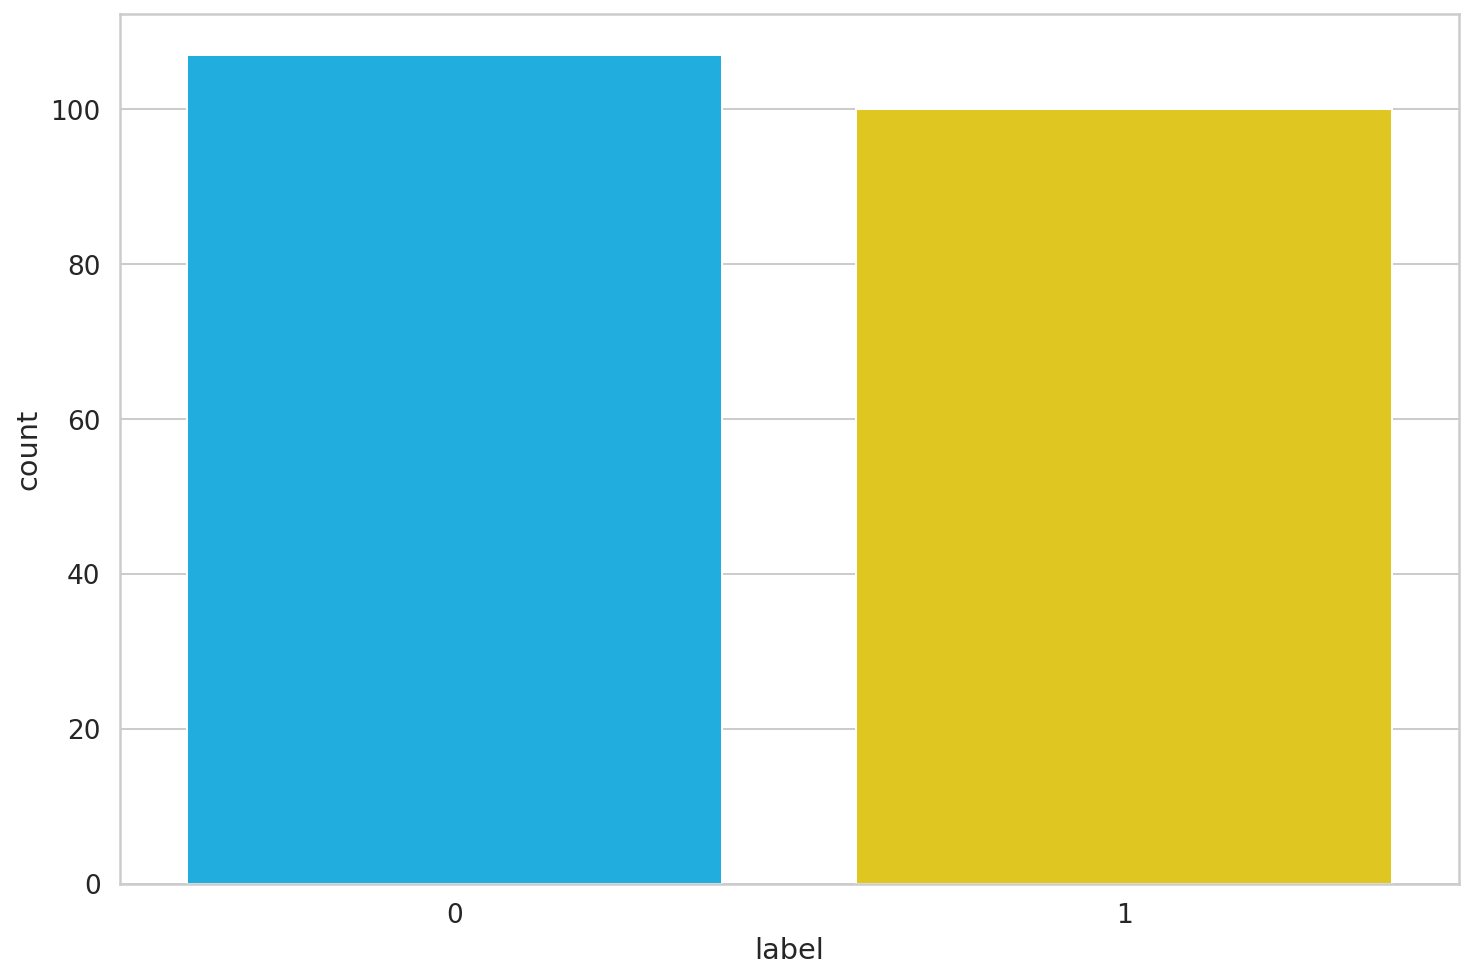

In [50]:
sns.countplot(df.label)
plt.xlabel('label');

In [51]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [52]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [53]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [54]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [55]:
print(len(encoding['input_ids'][0]))

encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [56]:
print(len(encoding['attention_mask'][0]))

encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [57]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [58]:
token_lens = []

for txt in df.sentence:

  tokens = tokenizer.encode(txt, max_length=512)

  token_lens.append(len(tokens))

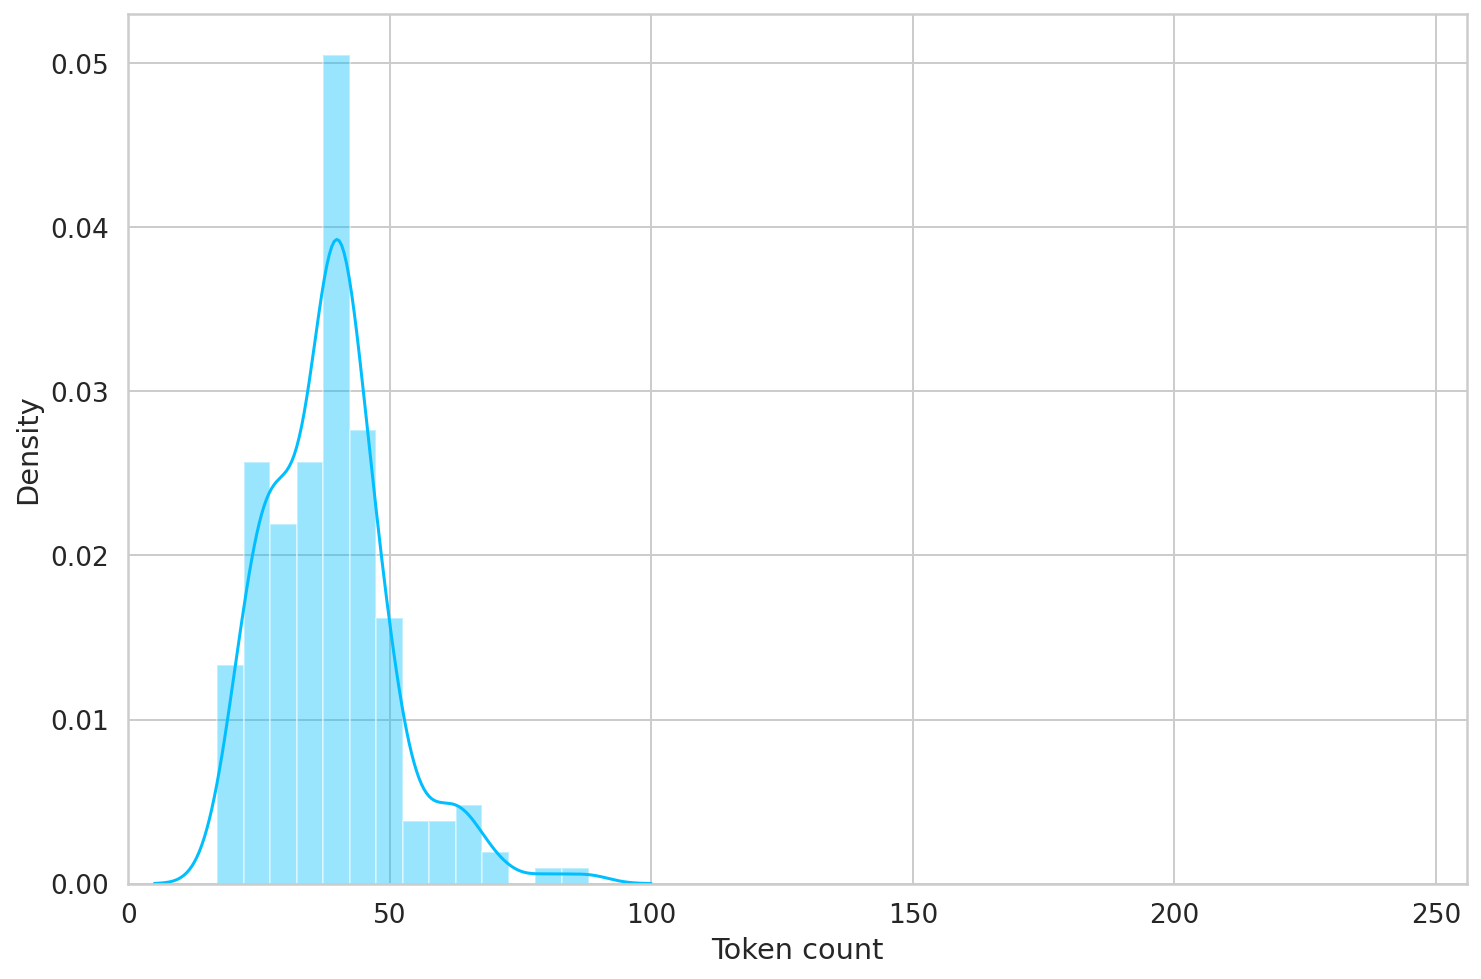

In [59]:
sns.distplot(token_lens)

plt.xlim([0, 256]);

plt.xlabel('Token count');

In [60]:
MAX_LEN = 100

In [61]:
class GPReviewDataset(Dataset):

  def __init__(self, sentence, label, tokenizer, max_len):

    self.sentence = sentence

    self.label = label

    self.tokenizer = tokenizer

    self.max_len = max_len

  def __len__(self):

    return len(self.sentence)

  def __getitem__(self, item):

    sentence = str(self.sentence[item])

    label = self.label[item]

    encoding = self.tokenizer.encode_plus(

      sentence,

      add_special_tokens=True,

      max_length=self.max_len,

      return_token_type_ids=False,

      pad_to_max_length=True,

      return_attention_mask=True,

      return_tensors='pt',

    )

    return {

      'sentence': sentence,

      'input_ids': encoding['input_ids'].flatten(),

      'attention_mask': encoding['attention_mask'].flatten(),

      'label': torch.tensor(label, dtype=torch.long)

    }

In [62]:
df_train, df_test = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED

)

In [63]:
df_train.shape, df_val.shape, df_test.shape

((175, 2), (16, 2), (16, 2))

In [64]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(

    sentence=df.sentence.to_numpy(),

    label=df.label.to_numpy(),

    tokenizer=tokenizer,

    max_len=max_len

  )

  return DataLoader(

    ds,

    batch_size=batch_size,

    num_workers=4

  )

In [65]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [66]:
data = next(iter(train_data_loader))

data.keys()

dict_keys(['sentence', 'input_ids', 'attention_mask', 'label'])

In [67]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['label'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


In [68]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
last_hidden_state, pooled_output = bert_model(

  input_ids=encoding['input_ids'],

  attention_mask=encoding['attention_mask']

)

In [70]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [71]:
pooled_output.shape

torch.Size([1, 768])

In [72]:
bert_model.config.hidden_size

768

In [73]:
class EP(nn.Module):

  def __init__(self, n_classes):

    super(EP, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p=0.1)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    output = self.drop(pooled_output)

    return self.out(output)

In [74]:
e_n_model = EP(2)

e_n_model = e_n_model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [75]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length

print(attention_mask.shape)

torch.Size([32, 100])
torch.Size([32, 100])


In [76]:
nn.functional.softmax(e_n_model(input_ids, attention_mask), dim=1)

tensor([[0.4985, 0.5015],
        [0.3716, 0.6284],
        [0.6278, 0.3722],
        [0.5026, 0.4974],
        [0.4475, 0.5525],
        [0.5413, 0.4587],
        [0.5333, 0.4667],
        [0.4677, 0.5323],
        [0.5650, 0.4350],
        [0.5478, 0.4522],
        [0.4944, 0.5056],
        [0.6029, 0.3971],
        [0.4212, 0.5788],
        [0.4572, 0.5428],
        [0.4312, 0.5688],
        [0.4235, 0.5765],
        [0.5475, 0.4525],
        [0.5806, 0.4194],
        [0.5748, 0.4252],
        [0.5722, 0.4278],
        [0.5198, 0.4802],
        [0.4488, 0.5512],
        [0.6025, 0.3975],
        [0.4196, 0.5804],
        [0.5253, 0.4747],
        [0.4947, 0.5053],
        [0.4191, 0.5809],
        [0.5515, 0.4485],
        [0.4935, 0.5065],
        [0.5201, 0.4799],
        [0.4543, 0.5457],
        [0.5252, 0.4748]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [77]:
EPOCHS = 10

optimizer = AdamW(e_n_model.parameters(), lr= 2e-5, correct_bias=True)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(

  optimizer,

  num_warmup_steps=0,

  num_training_steps=total_steps

)

loss_fn = nn.CrossEntropyLoss().to(device)

In [78]:
def train_epoch(

  model,

  data_loader,

  loss_fn,

  optimizer,

  device,

  scheduler,

  n_examples

):

  model = model.train()

  losses = []

  correct_predictions = 0

  for d in data_loader:

    input_ids = d["input_ids"].to(device)

    attention_mask = d["attention_mask"].to(device)

    targets = d["label"].to(device)

    outputs = model(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [79]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []

  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)

      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [80]:
%%time

history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')

  print('-' * 10)

  train_acc, train_loss = train_epoch(

    e_n_model,

    train_data_loader,

    loss_fn,

    optimizer,

    device,

    scheduler,

    len(df_train)

  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(

    e_n_model,

    val_data_loader,

    loss_fn,

    device,

    len(df_val)

  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc.item())

  history['train_loss'].append(train_loss.item())

  history['val_acc'].append(val_acc.item())

  history['val_loss'].append(val_loss.item())

  if val_acc > best_accuracy:

    torch.save(e_n_model.state_dict(), 'best_e_n_model_state.bin')

    best_accuracy = val_acc



Epoch 1/10
----------
Train loss 0.7015147904555002 accuracy 0.5142857142857142
Val   loss 0.6952580213546753 accuracy 0.5

Epoch 2/10
----------
Train loss 0.6642018953959147 accuracy 0.6228571428571429
Val   loss 0.6695274114608765 accuracy 0.6875

Epoch 3/10
----------
Train loss 0.6590113441149393 accuracy 0.6228571428571429
Val   loss 0.6489952802658081 accuracy 0.625

Epoch 4/10
----------
Train loss 0.602146158615748 accuracy 0.7257142857142858
Val   loss 0.6292126178741455 accuracy 0.5625

Epoch 5/10
----------
Train loss 0.5606575111548106 accuracy 0.7314285714285714
Val   loss 0.5863146185874939 accuracy 0.6875

Epoch 6/10
----------
Train loss 0.46983321011066437 accuracy 0.84
Val   loss 0.5596564412117004 accuracy 0.6875

Epoch 7/10
----------
Train loss 0.4178479661544164 accuracy 0.8914285714285715
Val   loss 0.5443065166473389 accuracy 0.8125

Epoch 8/10
----------
Train loss 0.3759654661019643 accuracy 0.8914285714285715
Val   loss 0.5328459739685059 accuracy 0.75

Epoc

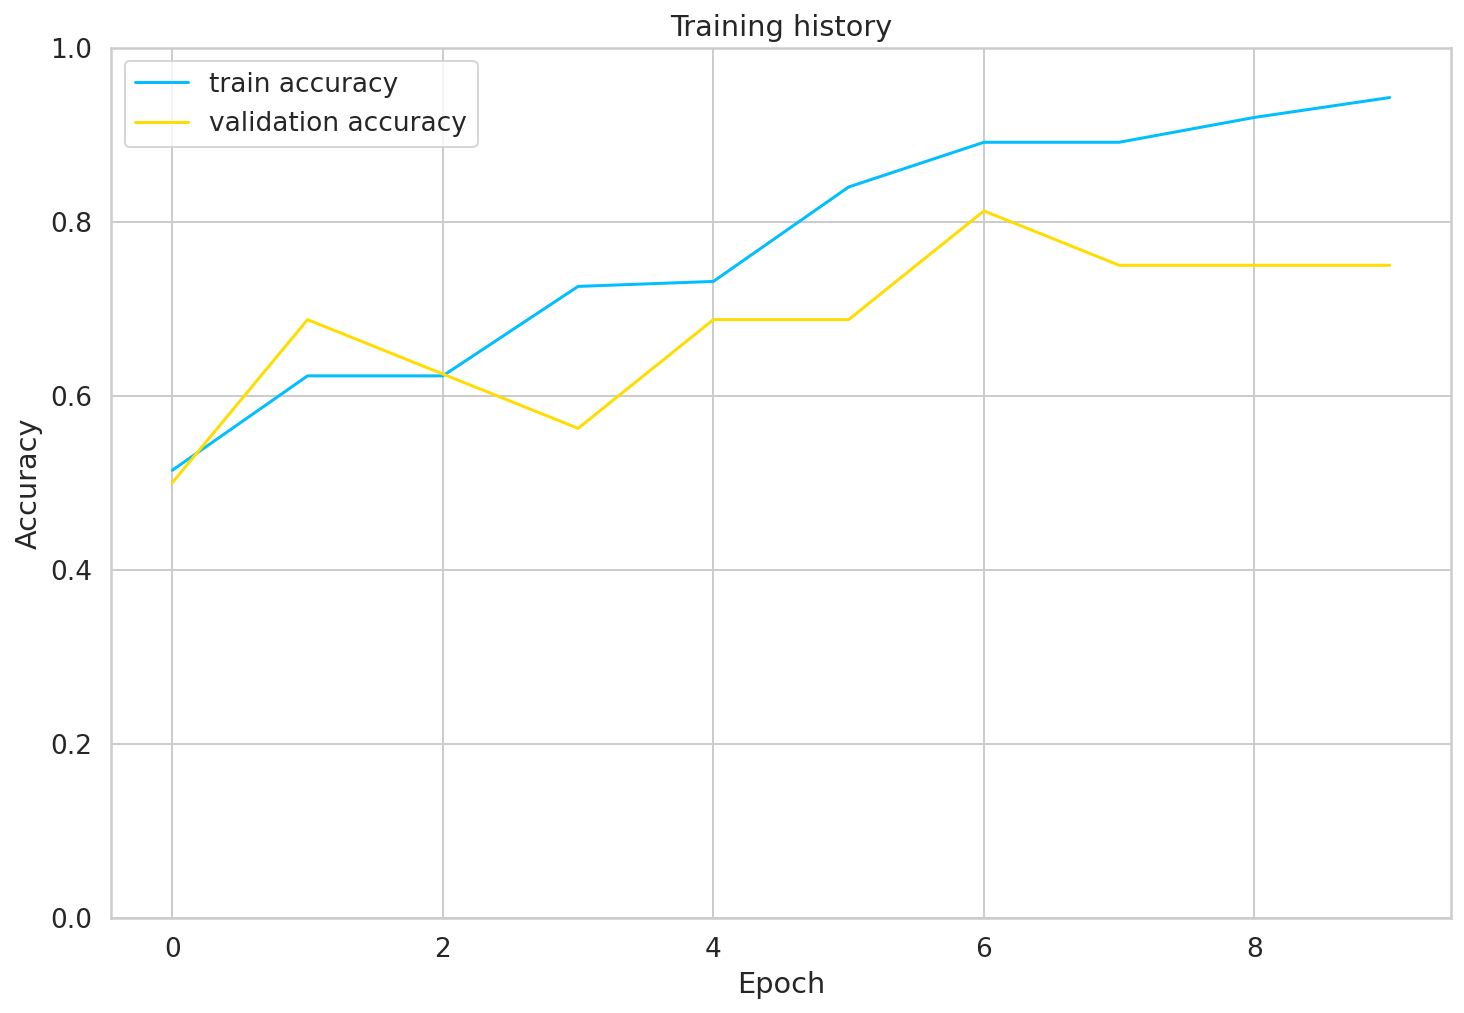

In [81]:


plt.plot(history['train_acc'], label='train accuracy')

plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [82]:
val_acc, _ = eval_model(

  e_n_model,

  val_data_loader,

  loss_fn,

  device,

  len(df_val)

)
val_acc.item()

0.75

In [83]:
test_acc, _ = eval_model(

  e_n_model,

  test_data_loader,

  loss_fn,

  device,

  len(df_test)

)

In [84]:

test_acc.item()

0.875

In [85]:
def get_predictions(model, data_loader):

  model = model.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d["sentence"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)

      predictions.extend(preds)

      prediction_probs.extend(outputs)

      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [86]:
y_review_texts_1, y_pred_model_1, y_pred_probs_1, y_test_1 = get_predictions(

  e_n_model,

  test_data_loader

)

### Prevent and None Model

In [87]:
p_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/prevent_df.csv'))
p_df['label'] = 0
n_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Semester Project Deepika, Amir/none_df.csv'), nrows=100)
n_df['label'] = 1
df = pd.concat([p_df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0', 'verb', 'trigger_1', 'trigger_2'], axis=1, inplace=True)


In [88]:
df

,sentence,label
0,The EU banned Belarusian planes from the bloc'...,0
1,Taipei has insisted it only wants to deal with...,0
2,EU leaders at their summit this week agreed in...,0
3,Iran's President Hassan Rouhani said Wednesday...,0
4,President Joe Biden has pledged to work with o...,0
...,...,...
193,Victoria had not recorded any locally acquired...,1
194,But repeated failures of the quarantine system...,1
195,"Australia -- which has recorded about 30,000 c...",1
196,New current affairs channel GB News on Wednesd...,1


In [89]:
'''
df = pd.concat([df, n_df], ignore_index=True, sort=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
'''

"\ndf = pd.concat([df, n_df], ignore_index=True, sort=False)\ndf.drop(['Unnamed: 0'], axis=1, inplace=True)\n"

In [90]:
df

,sentence,label
0,The EU banned Belarusian planes from the bloc'...,0
1,Taipei has insisted it only wants to deal with...,0
2,EU leaders at their summit this week agreed in...,0
3,Iran's President Hassan Rouhani said Wednesday...,0
4,President Joe Biden has pledged to work with o...,0
...,...,...
193,Victoria had not recorded any locally acquired...,1
194,But repeated failures of the quarantine system...,1
195,"Australia -- which has recorded about 30,000 c...",1
196,New current affairs channel GB News on Wednesd...,1


In [91]:
df.shape

(198, 2)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  198 non-null    object
 1   label     198 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


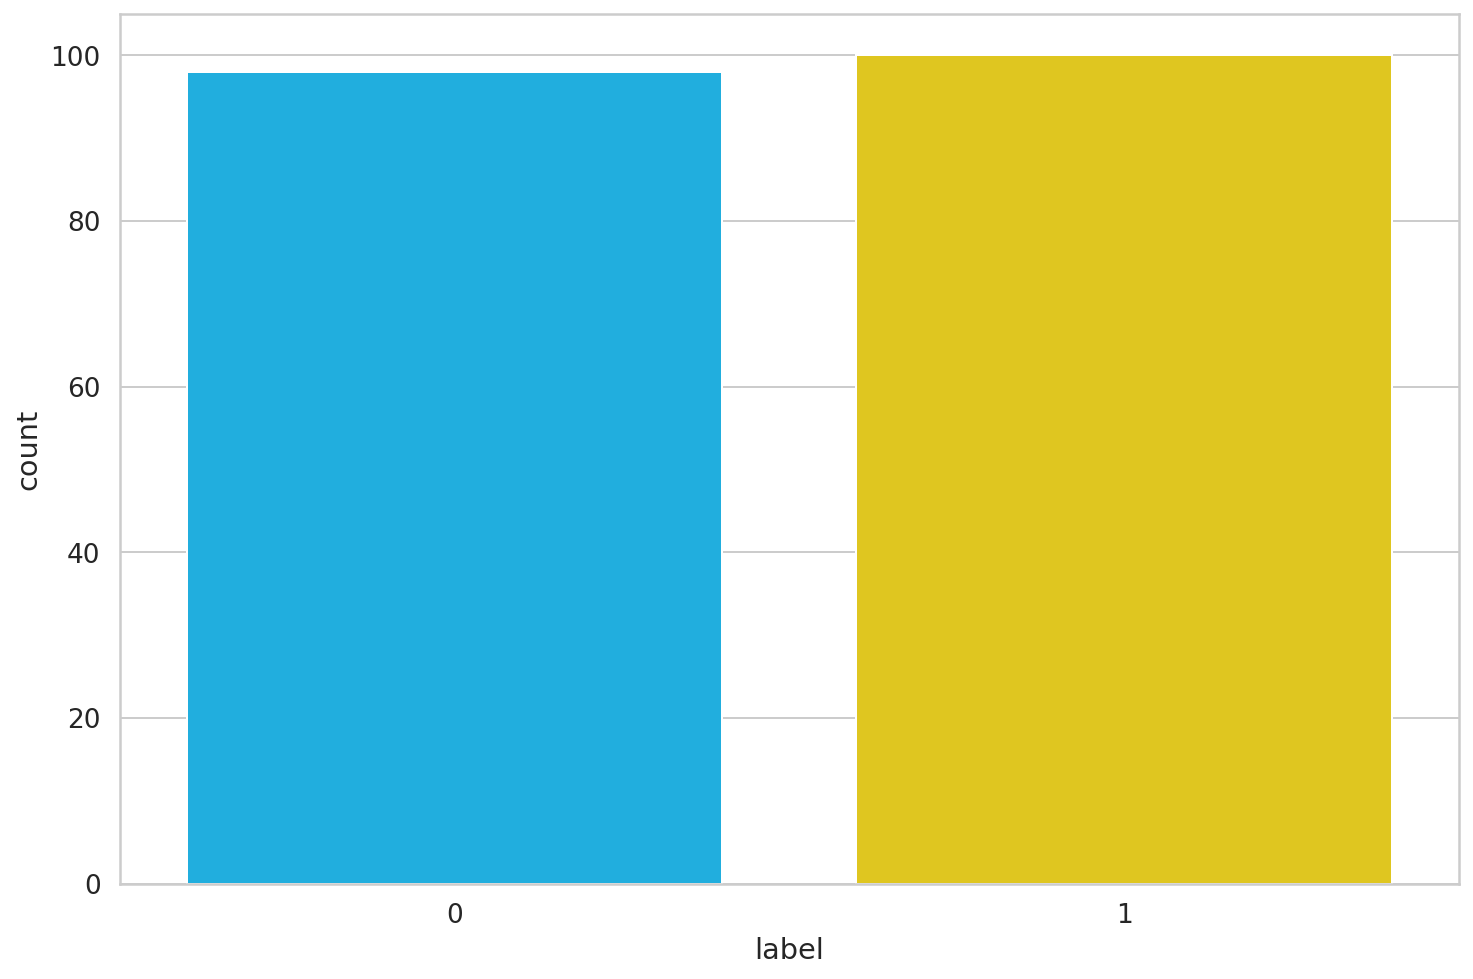

In [93]:
sns.countplot(df.label)
plt.xlabel('label');

In [94]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [95]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [96]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [97]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [98]:
print(len(encoding['input_ids'][0]))

encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [99]:
print(len(encoding['attention_mask'][0]))

encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [100]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [101]:
token_lens = []

for txt in df.sentence:

  tokens = tokenizer.encode(txt, max_length=512)

  token_lens.append(len(tokens))

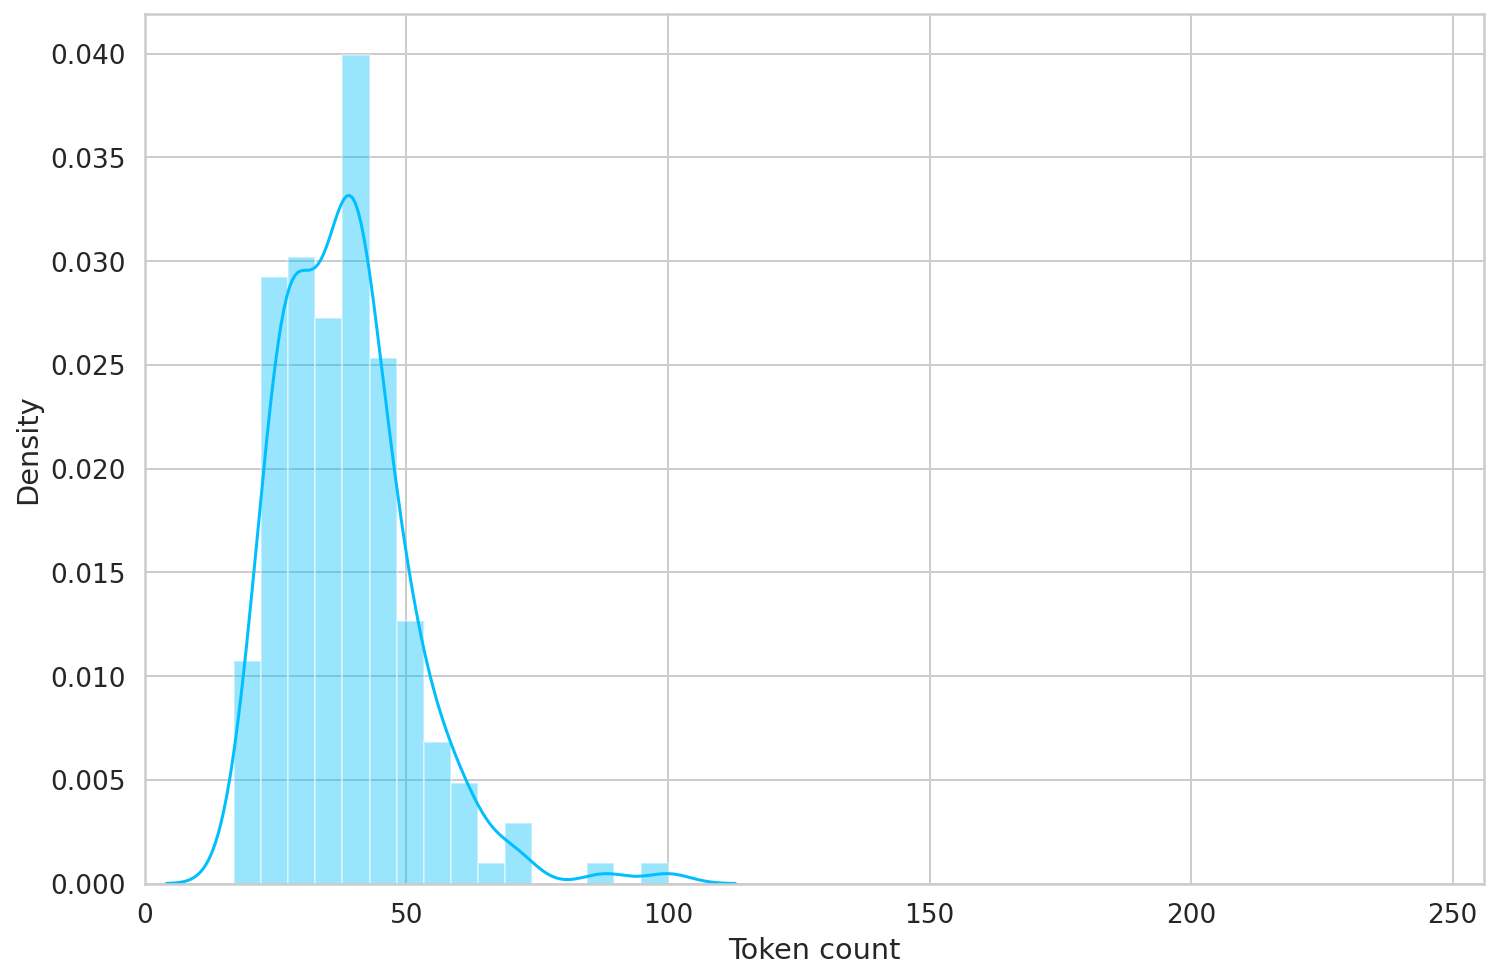

In [102]:
sns.distplot(token_lens)

plt.xlim([0, 256]);

plt.xlabel('Token count');

In [103]:
MAX_LEN = 100

In [104]:
class GPReviewDataset(Dataset):

  def __init__(self, sentence, label, tokenizer, max_len):

    self.sentence = sentence

    self.label = label

    self.tokenizer = tokenizer

    self.max_len = max_len

  def __len__(self):

    return len(self.sentence)

  def __getitem__(self, item):

    sentence = str(self.sentence[item])

    label = self.label[item]

    encoding = self.tokenizer.encode_plus(

      sentence,

      add_special_tokens=True,

      max_length=self.max_len,

      return_token_type_ids=False,

      pad_to_max_length=True,

      return_attention_mask=True,

      return_tensors='pt',

    )

    return {

      'sentence': sentence,

      'input_ids': encoding['input_ids'].flatten(),

      'attention_mask': encoding['attention_mask'].flatten(),

      'label': torch.tensor(label, dtype=torch.long)

    }

In [105]:
df_train, df_test = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED

)

In [106]:
df_train.shape, df_val.shape, df_test.shape

((168, 2), (15, 2), (15, 2))

In [107]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(

    sentence=df.sentence.to_numpy(),

    label=df.label.to_numpy(),

    tokenizer=tokenizer,

    max_len=max_len

  )

  return DataLoader(

    ds,

    batch_size=batch_size,

    num_workers=4

  )

In [108]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [109]:
data = next(iter(train_data_loader))

data.keys()

dict_keys(['sentence', 'input_ids', 'attention_mask', 'label'])

In [110]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['label'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


In [111]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [112]:
last_hidden_state, pooled_output = bert_model(

  input_ids=encoding['input_ids'],

  attention_mask=encoding['attention_mask']

)

In [113]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [114]:
pooled_output.shape

torch.Size([1, 768])

In [115]:
bert_model.config.hidden_size

768

In [116]:
class EP(nn.Module):

  def __init__(self, n_classes):

    super(EP, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p=0.1)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    output = self.drop(pooled_output)

    return self.out(output)

In [117]:
p_n_model = EP(2)

p_n_model = p_n_model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [118]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length

print(attention_mask.shape)

torch.Size([32, 100])
torch.Size([32, 100])


In [119]:
nn.functional.softmax(p_n_model(input_ids, attention_mask), dim=1)

tensor([[0.3870, 0.6130],
        [0.3693, 0.6307],
        [0.3764, 0.6236],
        [0.4249, 0.5751],
        [0.4605, 0.5395],
        [0.4930, 0.5070],
        [0.4408, 0.5592],
        [0.5713, 0.4287],
        [0.4008, 0.5992],
        [0.3390, 0.6610],
        [0.3548, 0.6452],
        [0.4279, 0.5721],
        [0.4325, 0.5675],
        [0.3860, 0.6140],
        [0.4541, 0.5459],
        [0.5965, 0.4035],
        [0.3839, 0.6161],
        [0.3531, 0.6469],
        [0.5420, 0.4580],
        [0.4919, 0.5081],
        [0.4776, 0.5224],
        [0.4743, 0.5257],
        [0.3535, 0.6465],
        [0.5287, 0.4713],
        [0.5183, 0.4817],
        [0.4374, 0.5626],
        [0.5934, 0.4066],
        [0.4826, 0.5174],
        [0.4931, 0.5069],
        [0.5799, 0.4201],
        [0.4846, 0.5154],
        [0.4251, 0.5749]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [120]:
EPOCHS = 10

optimizer = AdamW(p_n_model.parameters(), lr= 2e-5, correct_bias=True)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(

  optimizer,

  num_warmup_steps=0,

  num_training_steps=total_steps

)

loss_fn = nn.CrossEntropyLoss().to(device)

In [121]:
def train_epoch(

  model,

  data_loader,

  loss_fn,

  optimizer,

  device,

  scheduler,

  n_examples

):

  model = model.train()

  losses = []

  correct_predictions = 0

  for d in data_loader:

    input_ids = d["input_ids"].to(device)

    attention_mask = d["attention_mask"].to(device)

    targets = d["label"].to(device)

    outputs = model(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [122]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []

  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)

      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [123]:
%%time

history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')

  print('-' * 10)

  train_acc, train_loss = train_epoch(

    p_n_model,

    train_data_loader,

    loss_fn,

    optimizer,

    device,

    scheduler,

    len(df_train)

  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(

    p_n_model,

    val_data_loader,

    loss_fn,

    device,

    len(df_val)

  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc.item())

  history['train_loss'].append(train_loss.item())

  history['val_acc'].append(val_acc.item())

  history['val_loss'].append(val_loss.item())

  if val_acc > best_accuracy:

    torch.save(p_n_model.state_dict(), 'best_p_n_model_state.bin')

    best_accuracy = val_acc



Epoch 1/10
----------
Train loss 0.6863492826620737 accuracy 0.5535714285714285
Val   loss 0.6499268412590027 accuracy 0.7333333333333333

Epoch 2/10
----------
Train loss 0.5796198497215906 accuracy 0.7321428571428571
Val   loss 0.48005545139312744 accuracy 0.9333333333333333

Epoch 3/10
----------
Train loss 0.44325227787097293 accuracy 0.8154761904761905
Val   loss 0.369613379240036 accuracy 0.8666666666666667

Epoch 4/10
----------
Train loss 0.39033959557612735 accuracy 0.8571428571428571
Val   loss 0.4721321165561676 accuracy 0.8

Epoch 5/10
----------
Train loss 0.30707476536432904 accuracy 0.8988095238095237
Val   loss 0.5304319262504578 accuracy 0.7333333333333333

Epoch 6/10
----------
Train loss 0.24728511025508246 accuracy 0.9285714285714285
Val   loss 0.595582127571106 accuracy 0.7333333333333333

Epoch 7/10
----------
Train loss 0.20680216824014983 accuracy 0.9523809523809523
Val   loss 0.5996793508529663 accuracy 0.7333333333333333

Epoch 8/10
----------
Train loss 0.202

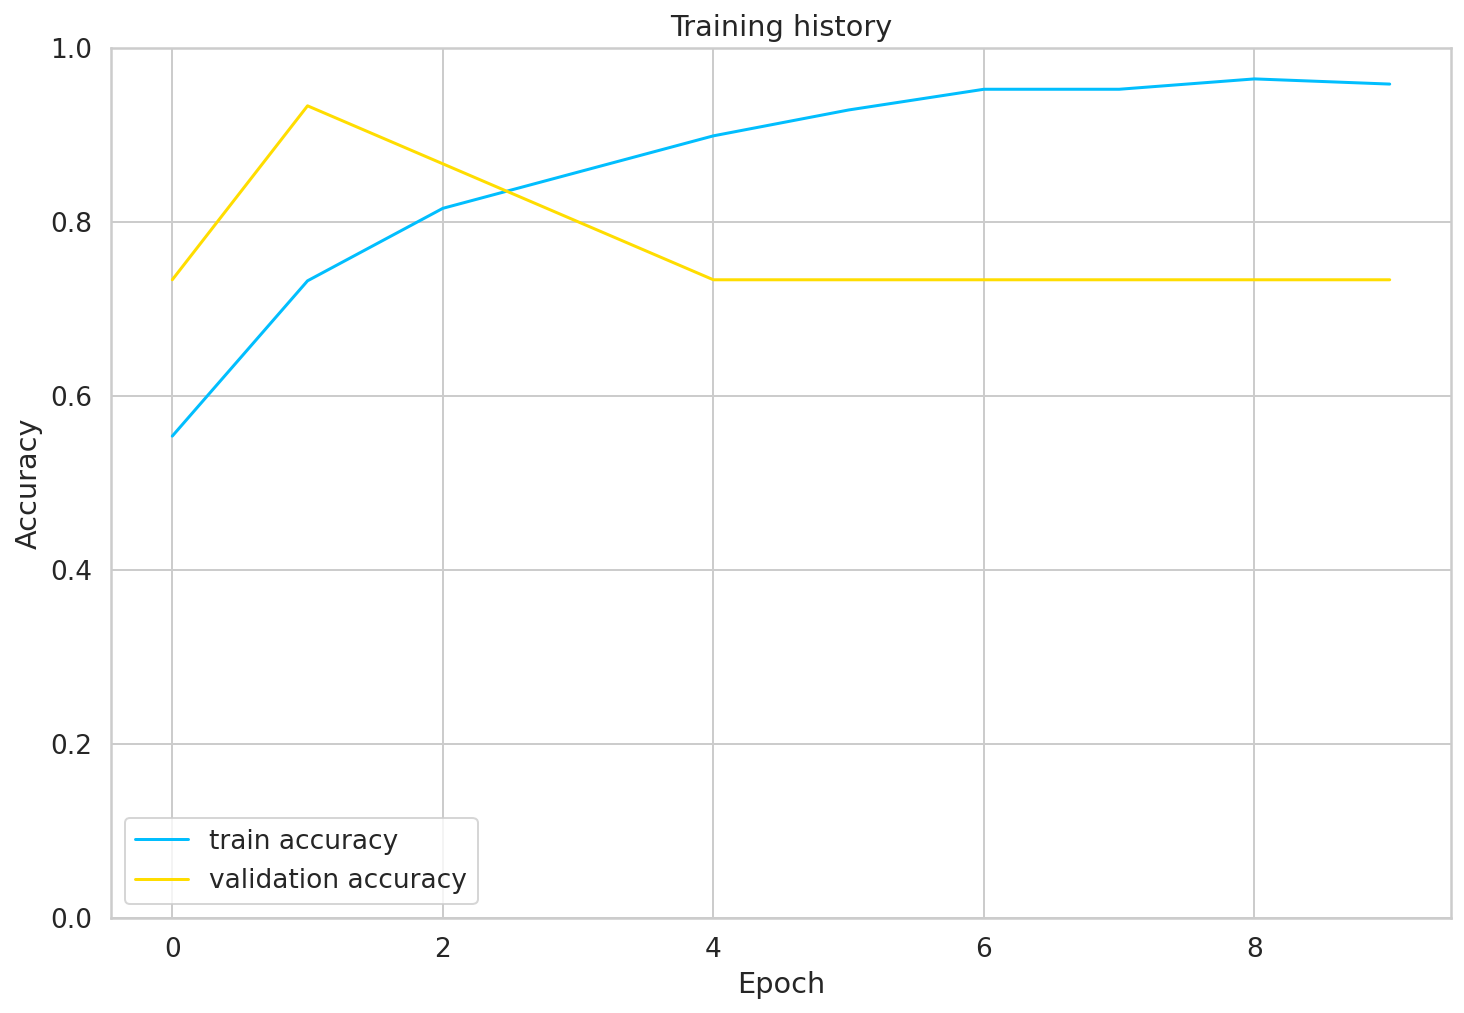

In [124]:


plt.plot(history['train_acc'], label='train accuracy')

plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [125]:
val_acc, _ = eval_model(

  p_n_model,

  val_data_loader,

  loss_fn,

  device,

  len(df_val)

)
val_acc.item()

0.7333333333333333

In [126]:
test_acc, _ = eval_model(

  p_n_model,

  test_data_loader,

  loss_fn,

  device,

  len(df_test)

)

In [127]:

test_acc.item()

0.5333333333333333

In [128]:
def get_predictions(model, data_loader):

  model = model.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d["sentence"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )
      print(outputs)  
      _, preds = torch.max(outputs, dim=1)
      print(preds)  
      review_texts.extend(texts)

      predictions.extend(preds)

      prediction_probs.extend(outputs)

      real_values.extend(targets)
      print(real_values)
      break
  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [129]:
y_review_texts_2, y_pred_model_2, y_pred_probs_2, y_test_2 = get_predictions(

  p_n_model,

  test_data_loader

)

tensor([[ 1.0720, -0.7734],
        [ 1.2204, -0.6538],
        [-1.0222,  1.2126],
        [ 1.2210, -0.6639],
        [-0.7774,  1.1729],
        [-1.0521,  1.2689],
        [ 1.1898, -0.7102],
        [-0.3014,  0.2199],
        [-0.5816,  0.9839],
        [ 1.1874, -0.6525],
        [ 1.1929, -0.7043],
        [-0.6808,  1.0632],
        [ 0.2994, -0.8947],
        [ 0.3023, -0.8966],
        [-0.1513, -0.3877]], device='cuda:0')
tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


In [130]:
print(y_pred_model_2,y_test_2, len(y_review_texts_2),'\n\n\n',y_review_texts_2)

tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]) tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]) 15 


 ['"Honestly, this is essentially air piracy," foreign ministry spokesman Anatoly Glaz said in a statement.', 'But Fed Vice Chair Randal Quarles again tried to tamp down concerns, saying current prices spikes are unlikely to last, and warning it would be "unwise" for the central bank to "take actions that might slow the recovery prematurely."', 'Haslund said UNHCR had received reports that as many as 700 displaced Tigrayans had been swept up in the operations.', 'Ukraine, which applied to join the US-led alliance in 2008, is pressing Western powers for more support as it seeks to deter any new aggression from Moscow.', "Former US lawmaker John Warner, who opposed George W. Bush's Iraq troop surge and was once married to Hollywood star Elizabeth Taylor, has died at the age of 94, reports said Wednesday.", 'Total said in a statement the decision was made at a May 12 meeting o

## Majority Hard Voting

In [ ]:
def majority_voting( model_1, model_2, data_loader, n_examples):
    
  model_1 = model_1.eval()

  model_2 = model_2.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      texts = d["sentence"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs_1 = model_1(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      outputs_2 = model_2(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds_1 = torch.max(outputs_1, dim=1)

      _, preds_2 = torch.max(outputs_2, dim=1)

     

      for i in range(len(preds_1)):
          if ((preds_1[i] == 1) & (preds_2[i] == 1)):
              preds_1[i] = 2
              outputs_1[i] = outputs_1[i]
          if ((preds_1[i] == 0)):
              preds_1[i] = 0
              outputs_1[i] = outputs_1[i]
          if preds_2[i] == 0:
              preds_1[i] = 1
              outputs_1[i] = outputs_2[i]
              
      review_texts.extend(texts)

      predictions.extend(preds_1)

      prediction_probs.extend(outputs_1)

      real_values.extend(targets)

      correct_predictions += torch.sum(preds_1 == targets)


  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()


  return review_texts, predictions, prediction_probs, real_values, correct_predictions.double()/n_examples

In [ ]:
y_review_texts_2, y_pred_model_2, y_pred_probs_2, y_test_2, accuracy = majority_voting(

  e_n_model,  

  p_n_model,

  test_data_loader,

  len(df_test)

)

In [ ]:
print(classification_report(y_test_2, y_pred_model_2, target_names=['enable','prevent','none']))

              precision    recall  f1-score   support

      enable       1.00      0.56      0.71         9
     prevent       0.60      0.75      0.67         8
        none       0.75      1.00      0.86         6

    accuracy                           0.74        23
   macro avg       0.78      0.77      0.75        23
weighted avg       0.80      0.74      0.73        23



In [ ]:
accuracy.item()

0.7391304347826086

In [ ]:
y_review_texts_2, y_pred_model_2, y_pred_probs_2, y_test_2, accuracy = majority_voting(

  e_n_model,  

  p_n_model,

  val_data_loader,

  len(df_val)

)

In [ ]:
accuracy.item()

0.8260869565217391

In [ ]:
for i in range(len(y_review_texts_2)):
    print('Text: ' + y_review_texts_2[i], '\nActual Label: ' + str(y_test_2[i].item()), '\nPredicted Label: ' + str(y_pred_model_2[i].item()), '\n\n')

Text: Through a strategic collaboration, AWS and Deloitte empower customers to transform their business and innovate faster by combining AWS technologies with Deloitte's deep industry experience. 
Actual Label: 0 
Predicted Label: 0 


Text: For 15 years, BIO KOREA has been a place of bringing together various international academics, professionals, and CEOs of global bio companies to obtain, exchange, and discuss diverse affairs. 
Actual Label: 2 
Predicted Label: 2 


Text:    Bryan, Garnier & Co is a European, full-service growth-focused independent investment banking partnership founded in 1996. 
Actual Label: 2 
Predicted Label: 2 


Text: Migrant workers in Lebanon have been hit hard by its multiple crises and half of them left jobless, the UN warned Wednesday, calling for voluntary returns to be scaled up. 
Actual Label: 0 
Predicted Label: 1 


Text: The following day he may have the perfect present in Manchester City's first Champions League crown. 
Actual Label: 2 
Predicted 

## Soft majority voting

In [193]:
def majority_soft_voting( model_1, model_2, data_loader, n_examples):
    
  model_1 = model_1.eval()

  model_2 = model_2.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      texts = d["sentence"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["label"].to(device)

      outputs_1 = model_1(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      outputs_2 = model_2(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      

      max_1, preds_1 = torch.max(outputs_1, dim=1)

      max_2, preds_2 = torch.max(outputs_2, dim=1)

      for i in range(len(preds_1)):
          if ((preds_1[i] == 1) & (preds_2[i] == 1)):
              if(max_1[i]>0.8) & (max_2[i] > 0.8):
                    preds_1[i] = 2
                    outputs_1[i] = max(max_1[i], max_2[i])
          if ((preds_1[i] == 0)):
              if max_1[i]>0.8:
                preds_1[i] = 0
                outputs_1[i] = max_1[i]
          if preds_2[i] == 0:
               if max_2[i]>0.8:
                    preds_1[i] = 1
                    outputs_1[i] = max_2[i]
              
      review_texts.extend(texts)

      predictions.extend(preds_1)

      prediction_probs.extend(outputs_1)

      real_values.extend(targets)

      correct_predictions += torch.sum(preds_1 == targets)


  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()


  return review_texts, predictions, prediction_probs, real_values, correct_predictions.double()/n_examples

In [194]:
y_review_texts_2, y_pred_model_2, y_pred_probs_2, y_test_2, accuracy = majority_soft_voting(

  e_n_model,  

  p_n_model,

  test_data_loader,

  len(df_test)

)

tensor([ 1.2077, -0.6892], device='cuda:0')


In [ ]:
print(classification_report(y_test_2, y_pred_model_2, target_names=['enable','prevent','none']))

In [189]:
accuracy.item()

0.6956521739130435

In [190]:
y_review_texts_2, y_pred_model_2, y_pred_probs_2, y_test_2, accuracy = majority_soft_voting(

  e_n_model,  

  p_n_model,

  val_data_loader,

  len(df_val)

)

In [185]:
accuracy.item()

0.7391304347826086